# Table of contents
* [1. Imports](#imports) 
* [2. Loading in dbCAN files](#dbcan) 
* [3. dbcan processing function](#dbcan-processing-function)
* [4. Processing GTDB taxonomy data](#GTDB)
* [5. Adding in MLST data](#mlst)
* [6. Creating heatmap](#heatmap)
* [7. Results: Frequency of CAZy families](#core-cazomes)

* [8. Summary table](#summary-table)
* [9. Preparing data for PCA plot](#pca-plot)
> * [10. Cumulative explained variance](#cev)
> * [11. Scree plot](#scree)
* [12. Analysing principal components (PCs)](#analysing-pcs)
* [13. Loading plots and CAZy families](#loading-plot)

### 1. Imports 
<a id="imports"></a>

In [1]:
#installing tool for dbcan
!pip3 install saintbioutils
!pip install adjustText

In [2]:
import os
import sys

import saintBioutils.utilities.file_io
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm.notebook import tqdm

from Bio import Entrez
from saintBioutils.genbank import entrez_retry

import adjustText

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from copy import copy

%matplotlib inline

Entrez.email = 'eemh1@st-andrews.ac.uk'

### 2. Loading in dbCAN files 
<a id="dbcan"></a>

In [3]:
from saintBioutils.utilities.file_io.get_paths import get_dir_paths
dbcan_path = "../data/dbcan_results"
dbcan_directories = get_dir_paths(dbcan_path)

### Creating functions
***Each line below refers to a seperate code block.***
1. Function "process_dbcan_output" which process dbcan output files. 
2. Function "getfamfrequences" which process dbcan output files.

In [4]:
def process_dbcan_output(dbcan_df,tool): #(Def)ining function name: process_dbcan_output(variables,variable) variables undefined currently
    """Removes e-number,domain range and + as well as turning turning all - into 0.
        Domain startwith gets rid of all starts with contained in that string
        
        dbcan_df: output files from dbCAN when turned into a df
        tool: dbcan predicted tools choose between (HMMER, DIAMOND and eCAMI)"""
    
    calling_for_column = dbcan_df[tool] #calling the column dataframe in tools
 
    new_processed_data = [] #Creating new column
    for data in calling_for_column: #Creating variable data in new filtered column
        if "-" == data: 
            new_processed_data.append("0")  #Takes all "-" and replaces with 0
        else:
            split_hmmer = data.split("+") #Otherwise split the data at the + sign useful for when there are multiple families
            hmmer_output = [hmmer_data.split("(",1)[0] for hmmer_data in split_hmmer] #split at the "(" for all hmmer data. Concatonaed list seperating at the ( using the (x in x for y) 
            processed_hmmer_data = "" #Creating a string to throw all the unneeded data into 
            for domain in hmmer_output: 
                if domain.startswith(("G","P","C","A")): #If domain starts with the following letters then...
                    processed_hmmer_data += f"{domain.split('_')[0]}+" #Create a string with the data split at the "_". first item index = [0]
            new_processed_data.append(processed_hmmer_data.strip()) #.strip to get rid of the newly made string

    dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
    return dbcan_df #returned processed df. send data back. 



In [5]:
#Creating function for calling cazy family frequences
def getfamfrequences(dbcan_output_path):
    """Load df in, filter dataframe to drop tools of 1. and drop EC number column. Use processed
    dbcan function which i will have to load in which will result in new_hmmer etc. Get consensus aka total.
    Use counter function to frequences of families and return that function.
    
    dbcan_output: db_can output dataframe
    output_path: the path which you have stored dbcan_output files"""
      
    #Loading in df, drop column
    df = pd.read_table(dbcan_output_path).drop(columns=["EC#"])  #Load dataframe and drop EC column
    df_filtered = df[df['#ofTools'] != 1] #Dropping all #oftools column which = 1 for consensous reasons
                                           
    #Function "process_dbcan_output" called in and used on HMMER,eCAMI and DIAMOND
    df_filtered = process_dbcan_output(df_filtered,"HMMER")
    df_filtered = process_dbcan_output(df_filtered,"eCAMI")
    df_filtered = process_dbcan_output(df_filtered,"DIAMOND")
    
                                               
    #Consensus data
    consensus_data = [] 

    for row_index in range(len(df_filtered)): 
        row = df_filtered.iloc[row_index] 
        hmmer_output = set(row["new_HMMER"].split("+"))
        ecami_output = set(row["new_eCAMI"].split("+"))
        diamond_output = set(row["new_DIAMOND"].split("+"))

        all_consensus = list(hmmer_output & diamond_output & ecami_output)
        hmmer_diamond_consensus = list(hmmer_output & diamond_output )
        hmmer_ecami_consensus = list(hmmer_output & ecami_output)
        diamond_ecami_consensus = list(diamond_output & ecami_output)

        consensus_fams = list(set(all_consensus + hmmer_diamond_consensus + hmmer_ecami_consensus + diamond_ecami_consensus))
        consensus_fams = [fams for fams in consensus_fams if len(fams)>0] 
        if len(consensus_fams) == 0: 
                consensus_fams = ["N"]
        consensus_data.append(consensus_fams)

    df_filtered["Consensus"] = consensus_data
    df_filtered
   
                                               
    #Use counter function to frequences of families
    total_consensus = []

    for row_data in consensus_data:
        for fam in row_data:
            if fam != 'N': 
                total_consensus.append(fam)
    counts = Counter(total_consensus)
                                
    return counts    

### 3. Creating dictionary once function is used to process data
<a id="dbcan-processing-function"></a>
***Each line below refers to a seperate code block.***
1. Create dictionary
2. Process that dictionary to extract all families contained in dict
3. Do the same for frequency data and create heatmap_df

In [6]:
#1. Creating CAZy family dictionary of processed data after using"getfamfrequences" function
dbcan_dict = {}
for dir_path in dbcan_directories:
    genomeID = "_".join(dir_path.name.split("_")[:2]).replace(".faa","") #Join function using split and getting rid .faa
    overview_path = dir_path/"overview.txt"
    count_freq = getfamfrequences(overview_path)
    dbcan_dict[genomeID] = count_freq



/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1708184232.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Consensus"] = consensus_data
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

In [7]:
#2. Identify all possible families. Loop thorugh the dictionary. FOR FAMILIES
all_families = set() #all_families.add to add to empty set. 
for genome in dbcan_dict:
    genome_counter = dbcan_dict[genome]
    for family in genome_counter:
        all_families.add(family) #all possible families
all_families = list(all_families)
all_families.sort()

#Loop through genome counter to get all families

In [8]:
#3. Create a list for heatmap_data to store all genome_counter data in. THIS IS FOR FREQUENCES
heatmap_data = []
for genome in dbcan_dict: 
    new_data = [genome] 
    genome_counter = dbcan_dict[genome]
    for fam in all_families:
        try:
            new_data.append(genome_counter[fam]) #is fam is in dict then add to the df
        except KeyError:
            new_data.append(0) #If family isn't in counter. Then new_data.append(0) else add cazy family freq
    heatmap_data.append(new_data)

column_name = ["genome"]
column_name += all_families
heatmap_df = pd.DataFrame(heatmap_data, columns = column_name)
heatmap_df

genome  AA10  AA3  AA4  AA5  AA7  CBM0  CBM10  CBM11  CBM12  \
0    GCA_007363395.1     5    2    0    1    0     1      0      0      4   
1    GCA_021496465.1     3    1    0    0    0     1      0      1      4   
2    GCA_009498275.1     3    2    0    0    1     1      0      1      2   
3    GCA_015767855.1     5    2    0    1    0     1      0      0      2   
4    GCA_013046785.1     3    1    0    0    0     1      0      1      0   
..               ...   ...  ...  ...  ...  ...   ...    ...    ...    ...   
413  GCA_025854275.1     4    2    0    0    0     1      0      1      2   
414  GCA_015767915.1     5    2    0    1    0     1      0      0      2   
415  GCA_003963535.1     4    4    0    0    0     1      0      1      2   
416  GCA_001278095.1     4    2    0    1    0     1      0      1      3   
417  GCA_000931445.1     5    1    0    0    0     1      0      0      3   

     ...  PL31  PL33  PL38  PL4  PL41  PL42  PL6  PL7  PL8  PL9  
0    ...     1     0     1    0     0     0    0    0    2    0  
1    ...     1     0     1    0     0     0    0    0    1    0  
2    ...     1     0     1    0     0     0    0    1    0    0  
3    ...     1     0     1    0     0     0    0    0    1    0  
4    ...     1     0     1    0     0     0    0    1    1    0  
..   ...   ...   ...   ...  ...   ...   ...  ...  ...  ...  ...  
413  ...     0     0     0    0     0     1    0    0    2    2  
414  ...     1     0     1    0     0     0    0    0    1    0  
415  ...     0     0     0    1     0     1    0    1    1    1  
416  ...     1     0     0    0     0     1    0    0    1    0  
417  ...     0     0     0    0     0     0    1    1    1    0  

[418 rows x 203 columns]

### 4. Processing GTDB taxonomy data
<a id="GTDB"></a>
***Each line below refers to a seperate code block.***

1. Loading in and tidying GTDB data
2. Adding taxnomy GTDB data into main heatmap dataframe
3. Function for all genomes which GTDB does not have taxonomy data on, retrieve this data from NCBI
4. Create new dataframe to store missing taxnomy data 
5. Create NCBI dictionary
6. Add missing GTDB taxonomy data into the main heatmap dataframe

In [9]:
#1. Processing GTDB data/tidying data
gtdb_df=pd.read_table("../data/taxnomy_data/bac120_taxonomy_17-2-23.tsv",header=None)#all tax info for all bac
gtdb_df.columns=["genome","taxonomy"] 
gtdb_tax = {}

#Looping through taxonomy data to get rid of unneeded columns. Only want to look at genus and species 
for i in tqdm(range(len(gtdb_df))):
    row = gtdb_df.iloc[i]
    genome = row["genome"]
    genome = genome.replace("RS_","")#RS_ = reference 
    genome = genome.replace("GB_","") #GB = genbank (which is removed)
    genus = "" 
    species = ""
    for data in row["taxonomy"].split(";"):
        if data.strip().startswith("g__"):
            genus = data.strip().replace("g__","").split("_")[0] #Split 0 is removing clade/group
            full_genus = data.strip().replace("g__","")
        elif data.strip().startswith("s__"):
            species = data.strip().replace("s__","").replace(full_genus,"").split("_")[0]
    gtdb_tax[genome]= {"species":species,"genus":genus} #Creating new key for species and genus         
    
print(gtdb_tax)

  0%|          | 0/311480 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
#2. Adding in taxonomy data into heatmap
#heatmap_df = heatmap_df.set_index(["genome"]) #sets it as a column 
genus_col = []
species_col = []
failed_genomes = []

for i in range(len(heatmap_df)):
    row = heatmap_df.iloc[i]
    genome = row["genome"]
    try:
        species = gtdb_tax[genome]["species"]
        genus = gtdb_tax[genome]["genus"] 
    except KeyError:
        try:
            genome_refseq = genome.replace("GCA","GCF")
            species = gtdb_tax[genome_refseq]["species"]
            genus = gtdb_tax[genome_refseq]["genus"] 
        except KeyError:
            print(f"could not get taxonomy for {genome}")
            failed_genomes.append(genome)
            species = ""
            genus = ""
        
    #Add genus to genus col and same for species
    species_col.append(species)
    genus_col.append(genus)
heatmap_df["genus"]= genus_col
heatmap_df["species"] = species_col
heatmap_df.to_csv("../data/taxnomy_data/family_freq.csv")
heatmap_df

could not get taxonomy for GCA_021496465.1
could not get taxonomy for GCA_024298965.1
could not get taxonomy for GCA_025231465.1
could not get taxonomy for GCA_019933235.1
could not get taxonomy for GCA_020535385.1
could not get taxonomy for GCA_001888885.2
could not get taxonomy for GCA_022846655.1
could not get taxonomy for GCA_000816465.4
could not get taxonomy for GCA_020783615.1
could not get taxonomy for GCA_025665295.1
could not get taxonomy for GCA_022695635.1
could not get taxonomy for GCA_023702105.1
could not get taxonomy for GCA_021665875.1
could not get taxonomy for GCA_021496785.1
could not get taxonomy for GCA_024758545.1
could not get taxonomy for GCA_025957665.1
could not get taxonomy for GCA_024611995.1
could not get taxonomy for GCA_024666385.1
could not get taxonomy for GCA_022846675.1
could not get taxonomy for GCA_022647665.1
could not get taxonomy for GCA_020616555.1
could not get taxonomy for GCA_019703895.1
could not get taxonomy for GCA_022869105.1
could not g

genome  AA10  AA3  AA4  AA5  AA7  CBM0  CBM10  CBM11  CBM12  \
0    GCA_007363395.1     5    2    0    1    0     1      0      0      4   
1    GCA_021496465.1     3    1    0    0    0     1      0      1      4   
2    GCA_009498275.1     3    2    0    0    1     1      0      1      2   
3    GCA_015767855.1     5    2    0    1    0     1      0      0      2   
4    GCA_013046785.1     3    1    0    0    0     1      0      1      0   
..               ...   ...  ...  ...  ...  ...   ...    ...    ...    ...   
413  GCA_025854275.1     4    2    0    0    0     1      0      1      2   
414  GCA_015767915.1     5    2    0    1    0     1      0      0      2   
415  GCA_003963535.1     4    4    0    0    0     1      0      1      2   
416  GCA_001278095.1     4    2    0    1    0     1      0      1      3   
417  GCA_000931445.1     5    1    0    0    0     1      0      0      3   

     ...  PL38  PL4  PL41  PL42  PL6  PL7  PL8  PL9         genus  \
0    ...     1    0     0     0    0    0    2    0  Streptomyces   
1    ...     1    0     0     0    0    0    1    0                 
2    ...     1    0     0     0    0    1    0    0  Streptomyces   
3    ...     1    0     0     0    0    0    1    0  Streptomyces   
4    ...     1    0     0     0    0    1    1    0  Streptomyces   
..   ...   ...  ...   ...   ...  ...  ...  ...  ...           ...   
413  ...     0    0     0     1    0    0    2    2                 
414  ...     1    0     0     0    0    0    1    0  Streptomyces   
415  ...     0    1     0     1    0    1    1    1  Streptomyces   
416  ...     0    0     0     1    0    0    1    0  Streptomyces   
417  ...     0    0     0     0    1    1    1    0  Streptomyces   

                species  
0           spectabilis  
1                        
2              fagopyri  
3          clavuligerus  
4           sp013046785  
..                  ...  
413                      
414        clavuligerus  
415   cyaneochromogenes  
416          bacillaris  
417       cyaneogriseus  

[418 rows x 205 columns]

In [11]:
#3. Function for retrieving taxonomic data from NCBI for failed_genomes
def get_ncbi_tax(genome):
    """Get the taxonomic classification for a genomic accession from NCBI Assembly
    
    :param genome: str, genomic version accession
    
    Return genus and species
    """
    organism = ""
    genus = ""
    species = ""
    
    # retrieve the ID of corresponding record in NCBI Assembly db
    try:
        with entrez_retry(
            10,
            Entrez.esearch,
            db="Assembly",
            term=genome,
        ) as accession_handle:
            record_meta_data = Entrez.read(accession_handle, validate=False)
    except (TypeError, AttributeError) as error:
        print(f"Could not retrieve tax data for {genome}")

    genome_record_id = record_meta_data['IdList'][0]

    # Fetch the record from the Assembly db, by querying by the record ID
    try:
        with entrez_retry(
            10,
            Entrez.efetch,
            db="Assembly",
            id=genome_record_id,
            rettype="docsum",
        ) as accession_handle:
            accession_record = Entrez.read(accession_handle, validate=False)
    except (TypeError, AttributeError) as error:
        print(f"Could not fetch tax data for {genome}\nError:{error}")

    # extract the organism name from the retrieved record
    for dictelemnt in accession_record['DocumentSummarySet']['DocumentSummary']:
        if str(dictelemnt).find(genome) != -1:
            organism = dictelemnt['Organism']
        
    genus = organism.split(" ")[0]
    species = organism.replace(genus, "").replace(" (high G+C Gram-positive bacteria)", "")
    
    return genus, species

In [12]:
#4. Create dataframe for columns genome taxonomy 
gtdb_df=pd.read_table("../data/taxnomy_data/bac120_taxonomy_17-2-23.tsv",header=None)
gtdb_df.columns=["genome","taxonomy"]
gtdb_df

genome                                           taxonomy
0       RS_GCF_000566285.1  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
1       RS_GCF_003460375.1  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
2       RS_GCF_008388435.1  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
3       RS_GCF_003000855.1  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
4       GB_GCA_904810065.1  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
...                    ...                                                ...
311475  GB_GCA_003222815.1  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...
311476  GB_GCA_910586715.1  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...
311477  GB_GCA_910583785.1  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...
311478  GB_GCA_017556805.1  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...
311479  RS_GCF_900116235.1  d__Bacteria;p__Firmicutes;c__Bacilli;o__Thermo...

[311480 rows x 2 columns]

In [13]:
#5. Create dictionary for failed taxonomy data
ncbi_taxs = {}  # {genomic acc: {genus: str, species: str}}

for genome in tqdm(failed_genomes, desc="Getting taxs from NCBI"):
    genus, species = get_ncbi_tax(genome)
    ncbi_taxs[genome] = {'genus': genus, 'species': species}
    
ncbi_taxs

Getting taxs from NCBI:   0%|          | 0/107 [00:00<?, ?it/s]

{'GCA_021496465.1': {'genus': 'Streptomyces', 'species': ' collinus'},
 'GCA_024298965.1': {'genus': 'Streptomyces',
  'species': ' rapamycinicus NRRL 5491'},
 'GCA_025231465.1': {'genus': 'Streptomyces', 'species': ' murinus'},
 'GCA_019933235.1': {'genus': 'Streptomyces', 'species': ' angustmyceticus'},
 'GCA_020535385.1': {'genus': 'Streptomyces', 'species': ' sp. WA1-19'},
 'GCA_001888885.2': {'genus': 'Streptomyces', 'species': ' viridifaciens'},
 'GCA_022846655.1': {'genus': 'Streptomyces', 'species': ' seoulensis'},
 'GCA_000816465.4': {'genus': 'Streptomyces', 'species': ' pluripotens'},
 'GCA_020783615.1': {'genus': 'Streptomyces', 'species': ' fungicidicus'},
 'GCA_025665295.1': {'genus': 'Streptomyces', 'species': ' sp. Je 1-4'},
 'GCA_022695635.1': {'genus': 'Streptomyces', 'species': ' sp. A10(2020)'},
 'GCA_023702105.1': {'genus': 'Streptomyces', 'species': ' lydicamycinicus'},
 'GCA_021665875.1': {'genus': 'Streptomyces', 'species': ' sp. AMCC400023'},
 'GCA_021496785.1'

In [14]:
#6. Adding taxonomy data to the main heatmap_df

genus_col = []
species_col = []

for i in tqdm(range(len(heatmap_df)), desc="Adding tax info"):  # desc= add a descriptive str to the pbar
    genome = heatmap_df.iloc[i]['genome']
    genus = ""
    species = ""
    
    # retrieve taxonomic info
    try:
        genus = gtdb_tax[genome]['genus'] #Find the genbank first
        species = gtdb_tax[genome]['species']
    except KeyError:
        # could not find tax info for GenBank acc
        # try refseq acc
        genome_refseq = genome.replace("GCA", "GCF")
        try:
            genus = gtdb_tax[genome_refseq]['genus']
            species = gtdb_tax[genome_refseq]['species']
        except KeyError:
            # try NCBI taxs
            try:
                genus = ncbi_taxs[genome]['genus']
                species = ncbi_taxs[genome]['species']
            except KeyError:
                # try refseq acc
                try:
                    genus = ncbi_taxs[genome_refseq]['genus']
                    species = ncbi_taxs[genome_refseq]['species']
                except KeyError:
                    print(f"Could not retrieve tax info for {genome}")
                    
    genus_col.append(genus)
    species_col.append(species)

#Adding in failed_genomes into the genus col
heatmap_df["genus"]=genus_col
heatmap_df["species"]=species_col

Adding tax info:   0%|          | 0/418 [00:00<?, ?it/s]

## 5. Adding in MLST data
<a id="mlst"></a>
***Each line below refers to a seperate code block.***

1. Adding Angelika's reference data for MLST and SCO into a new df


In [15]:
#1. Adding in Angelika's data in
sco_df=pd.read_csv("../data/genomes/SCO_tree_metadata.csv") #all tax info for all bac
sco_df 

mlst=[]
sco=[]

for ri in range(len(heatmap_df)):#ri = row index 
    row = heatmap_df.iloc[ri]  #Iterate row 
    accession = row["genome"]  #Just accession row grab
    gcf = accession.replace("GCA","GCF") #replace (old,new)
    rows=sco_df[sco_df["Accession"]==gcf] #filtering for rows which inside the named column which match gcf variable
    if len(rows)==0:
        mlst.append("Unclassified") #append to add (put whatever you want, list, string etc)
        sco.append("Unclassified")
        continue #STOP iteration and go onto the next line of code
    first_row=rows.iloc[0] #assume appear once
    mlst_id=first_row["MLST_group_ID"]
    sco_id=first_row["SCO_group_ID"]
    mlst.append(mlst_id)
    sco.append(sco_id)
    
heatmap_df["MLST_group_ID"]=mlst
heatmap_df["SCO_group_ID"]=sco
print(len(mlst),len(sco),len(heatmap_df))
heatmap_df
        

418 418 418


genome  AA10  AA3  AA4  AA5  AA7  CBM0  CBM10  CBM11  CBM12  \
0    GCA_007363395.1     5    2    0    1    0     1      0      0      4   
1    GCA_021496465.1     3    1    0    0    0     1      0      1      4   
2    GCA_009498275.1     3    2    0    0    1     1      0      1      2   
3    GCA_015767855.1     5    2    0    1    0     1      0      0      2   
4    GCA_013046785.1     3    1    0    0    0     1      0      1      0   
..               ...   ...  ...  ...  ...  ...   ...    ...    ...    ...   
413  GCA_025854275.1     4    2    0    0    0     1      0      1      2   
414  GCA_015767915.1     5    2    0    1    0     1      0      0      2   
415  GCA_003963535.1     4    4    0    0    0     1      0      1      2   
416  GCA_001278095.1     4    2    0    1    0     1      0      1      3   
417  GCA_000931445.1     5    1    0    0    0     1      0      0      3   

     ...  PL41  PL42  PL6  PL7  PL8  PL9         genus             species  \
0    ...     0     0    0    0    2    0  Streptomyces         spectabilis   
1    ...     0     0    0    0    1    0  Streptomyces            collinus   
2    ...     0     0    0    1    0    0  Streptomyces            fagopyri   
3    ...     0     0    0    0    1    0  Streptomyces        clavuligerus   
4    ...     0     0    0    1    1    0  Streptomyces         sp013046785   
..   ...   ...   ...  ...  ...  ...  ...           ...                 ...   
413  ...     0     1    0    0    2    2  Streptomyces           peucetius   
414  ...     0     0    0    0    1    0  Streptomyces        clavuligerus   
415  ...     0     1    0    1    1    1  Streptomyces   cyaneochromogenes   
416  ...     0     1    0    0    1    0  Streptomyces          bacillaris   
417  ...     0     0    1    1    1    0  Streptomyces       cyaneogriseus   

     MLST_group_ID  SCO_group_ID  
0     Unclassified  Unclassified  
1     Unclassified  Unclassified  
2     Unclassified  Unclassified  
3     Unclassified  Unclassified  
4              255             3  
..             ...           ...  
413   Unclassified  Unclassified  
414   Unclassified  Unclassified  
415            244             3  
416   Unclassified  Unclassified  
417            229             3  

[418 rows x 207 columns]

## 6. Creating heatmap
<a id="heatmap"></a>
***Each line below refers to a seperate code block.***
1. Call heatmap_df to see current stucture 
2. Setting row title placement
3. Double checking heatmap_df structure
4. Generating heatmap_df

In [16]:
#1. Call heatmap
heatmap_df


genome  AA10  AA3  AA4  AA5  AA7  CBM0  CBM10  CBM11  CBM12  \
0    GCA_007363395.1     5    2    0    1    0     1      0      0      4   
1    GCA_021496465.1     3    1    0    0    0     1      0      1      4   
2    GCA_009498275.1     3    2    0    0    1     1      0      1      2   
3    GCA_015767855.1     5    2    0    1    0     1      0      0      2   
4    GCA_013046785.1     3    1    0    0    0     1      0      1      0   
..               ...   ...  ...  ...  ...  ...   ...    ...    ...    ...   
413  GCA_025854275.1     4    2    0    0    0     1      0      1      2   
414  GCA_015767915.1     5    2    0    1    0     1      0      0      2   
415  GCA_003963535.1     4    4    0    0    0     1      0      1      2   
416  GCA_001278095.1     4    2    0    1    0     1      0      1      3   
417  GCA_000931445.1     5    1    0    0    0     1      0      0      3   

     ...  PL41  PL42  PL6  PL7  PL8  PL9         genus             species  \
0    ...     0     0    0    0    2    0  Streptomyces         spectabilis   
1    ...     0     0    0    0    1    0  Streptomyces            collinus   
2    ...     0     0    0    1    0    0  Streptomyces            fagopyri   
3    ...     0     0    0    0    1    0  Streptomyces        clavuligerus   
4    ...     0     0    0    1    1    0  Streptomyces         sp013046785   
..   ...   ...   ...  ...  ...  ...  ...           ...                 ...   
413  ...     0     1    0    0    2    2  Streptomyces           peucetius   
414  ...     0     0    0    0    1    0  Streptomyces        clavuligerus   
415  ...     0     1    0    1    1    1  Streptomyces   cyaneochromogenes   
416  ...     0     1    0    0    1    0  Streptomyces          bacillaris   
417  ...     0     0    1    1    1    0  Streptomyces       cyaneogriseus   

     MLST_group_ID  SCO_group_ID  
0     Unclassified  Unclassified  
1     Unclassified  Unclassified  
2     Unclassified  Unclassified  
3     Unclassified  Unclassified  
4              255             3  
..             ...           ...  
413   Unclassified  Unclassified  
414   Unclassified  Unclassified  
415            244             3  
416   Unclassified  Unclassified  
417            229             3  

[418 rows x 207 columns]

In [17]:
#2. Setting row title
heatmap_df=heatmap_df.set_index(["genome","genus","species"]) #Become row names but finalises its placement

In [18]:
# 3. Double checking heatmap_df structure
heatmap_df 

AA10  AA3  AA4  AA5  AA7  \
genome          genus        species                                        
GCA_007363395.1 Streptomyces  spectabilis           5    2    0    1    0   
GCA_021496465.1 Streptomyces  collinus              3    1    0    0    0   
GCA_009498275.1 Streptomyces  fagopyri              3    2    0    0    1   
GCA_015767855.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_013046785.1 Streptomyces  sp013046785           3    1    0    0    0   
...                                               ...  ...  ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius             4    2    0    0    0   
GCA_015767915.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     4    4    0    0    0   
GCA_001278095.1 Streptomyces  bacillaris            4    2    0    1    0   
GCA_000931445.1 Streptomyces  cyaneogriseus         5    1    0    0    0   

                                                 CBM0  CBM10  CBM11  CBM12  \
genome          genus        species                                         
GCA_007363395.1 Streptomyces  spectabilis           1      0      0      4   
GCA_021496465.1 Streptomyces  collinus              1      0      1      4   
GCA_009498275.1 Streptomyces  fagopyri              1      0      1      2   
GCA_015767855.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_013046785.1 Streptomyces  sp013046785           1      0      1      0   
...                                               ...    ...    ...    ...   
GCA_025854275.1 Streptomyces  peucetius             1      0      1      2   
GCA_015767915.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_003963535.1 Streptomyces  cyaneochromogenes     1      0      1      2   
GCA_001278095.1 Streptomyces  bacillaris            1      0      1      3   
GCA_000931445.1 Streptomyces  cyaneogriseus         1      0      0      3   

                                                 CBM13  ...  PL38  PL4  PL41  \
genome          genus        species                    ...                    
GCA_007363395.1 Streptomyces  spectabilis            5  ...     1    0     0   
GCA_021496465.1 Streptomyces  collinus               8  ...     1    0     0   
GCA_009498275.1 Streptomyces  fagopyri              11  ...     1    0     0   
GCA_015767855.1 Streptomyces  clavuligerus          10  ...     1    0     0   
GCA_013046785.1 Streptomyces  sp013046785           16  ...     1    0     0   
...                                                ...  ...   ...  ...   ...   
GCA_025854275.1 Streptomyces  peucetius             14  ...     0    0     0   
GCA_015767915.1 Streptomyces  clavuligerus          10  ...     1    0     0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     34  ...     0    1     0   
GCA_001278095.1 Streptomyces  bacillaris             4  ...     0    0     0   
GCA_000931445.1 Streptomyces  cyaneogriseus          9  ...     0    0     0   

                                                 PL42  PL6  PL7  PL8  PL9  \
genome          genus        species                                        
GCA_007363395.1 Streptomyces  spectabilis           0    0    0    2    0   
GCA_021496465.1 Streptomyces  collinus              0    0    0    1    0   
GCA_009498275.1 Streptomyces  fagopyri              0    0    1    0    0   
GCA_015767855.1 Streptomyces  clavuligerus          0    0    0    1    0   
GCA_013046785.1 Streptomyces  sp013046785           0    0    1    1    0   
...                                               ...  ...  ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius             1    0    0    2    2   
GCA_015767915.1 Streptomyces  clavuligerus          0    0    0    1    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     1    0    1    1    1   
GCA_001278095.1 Streptomyces  bacillaris            1    0    0    1    0   
GCA_000931445.1 Streptomyces  cyaneogriseus         0    1    1    

/Users/sabrinalau/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


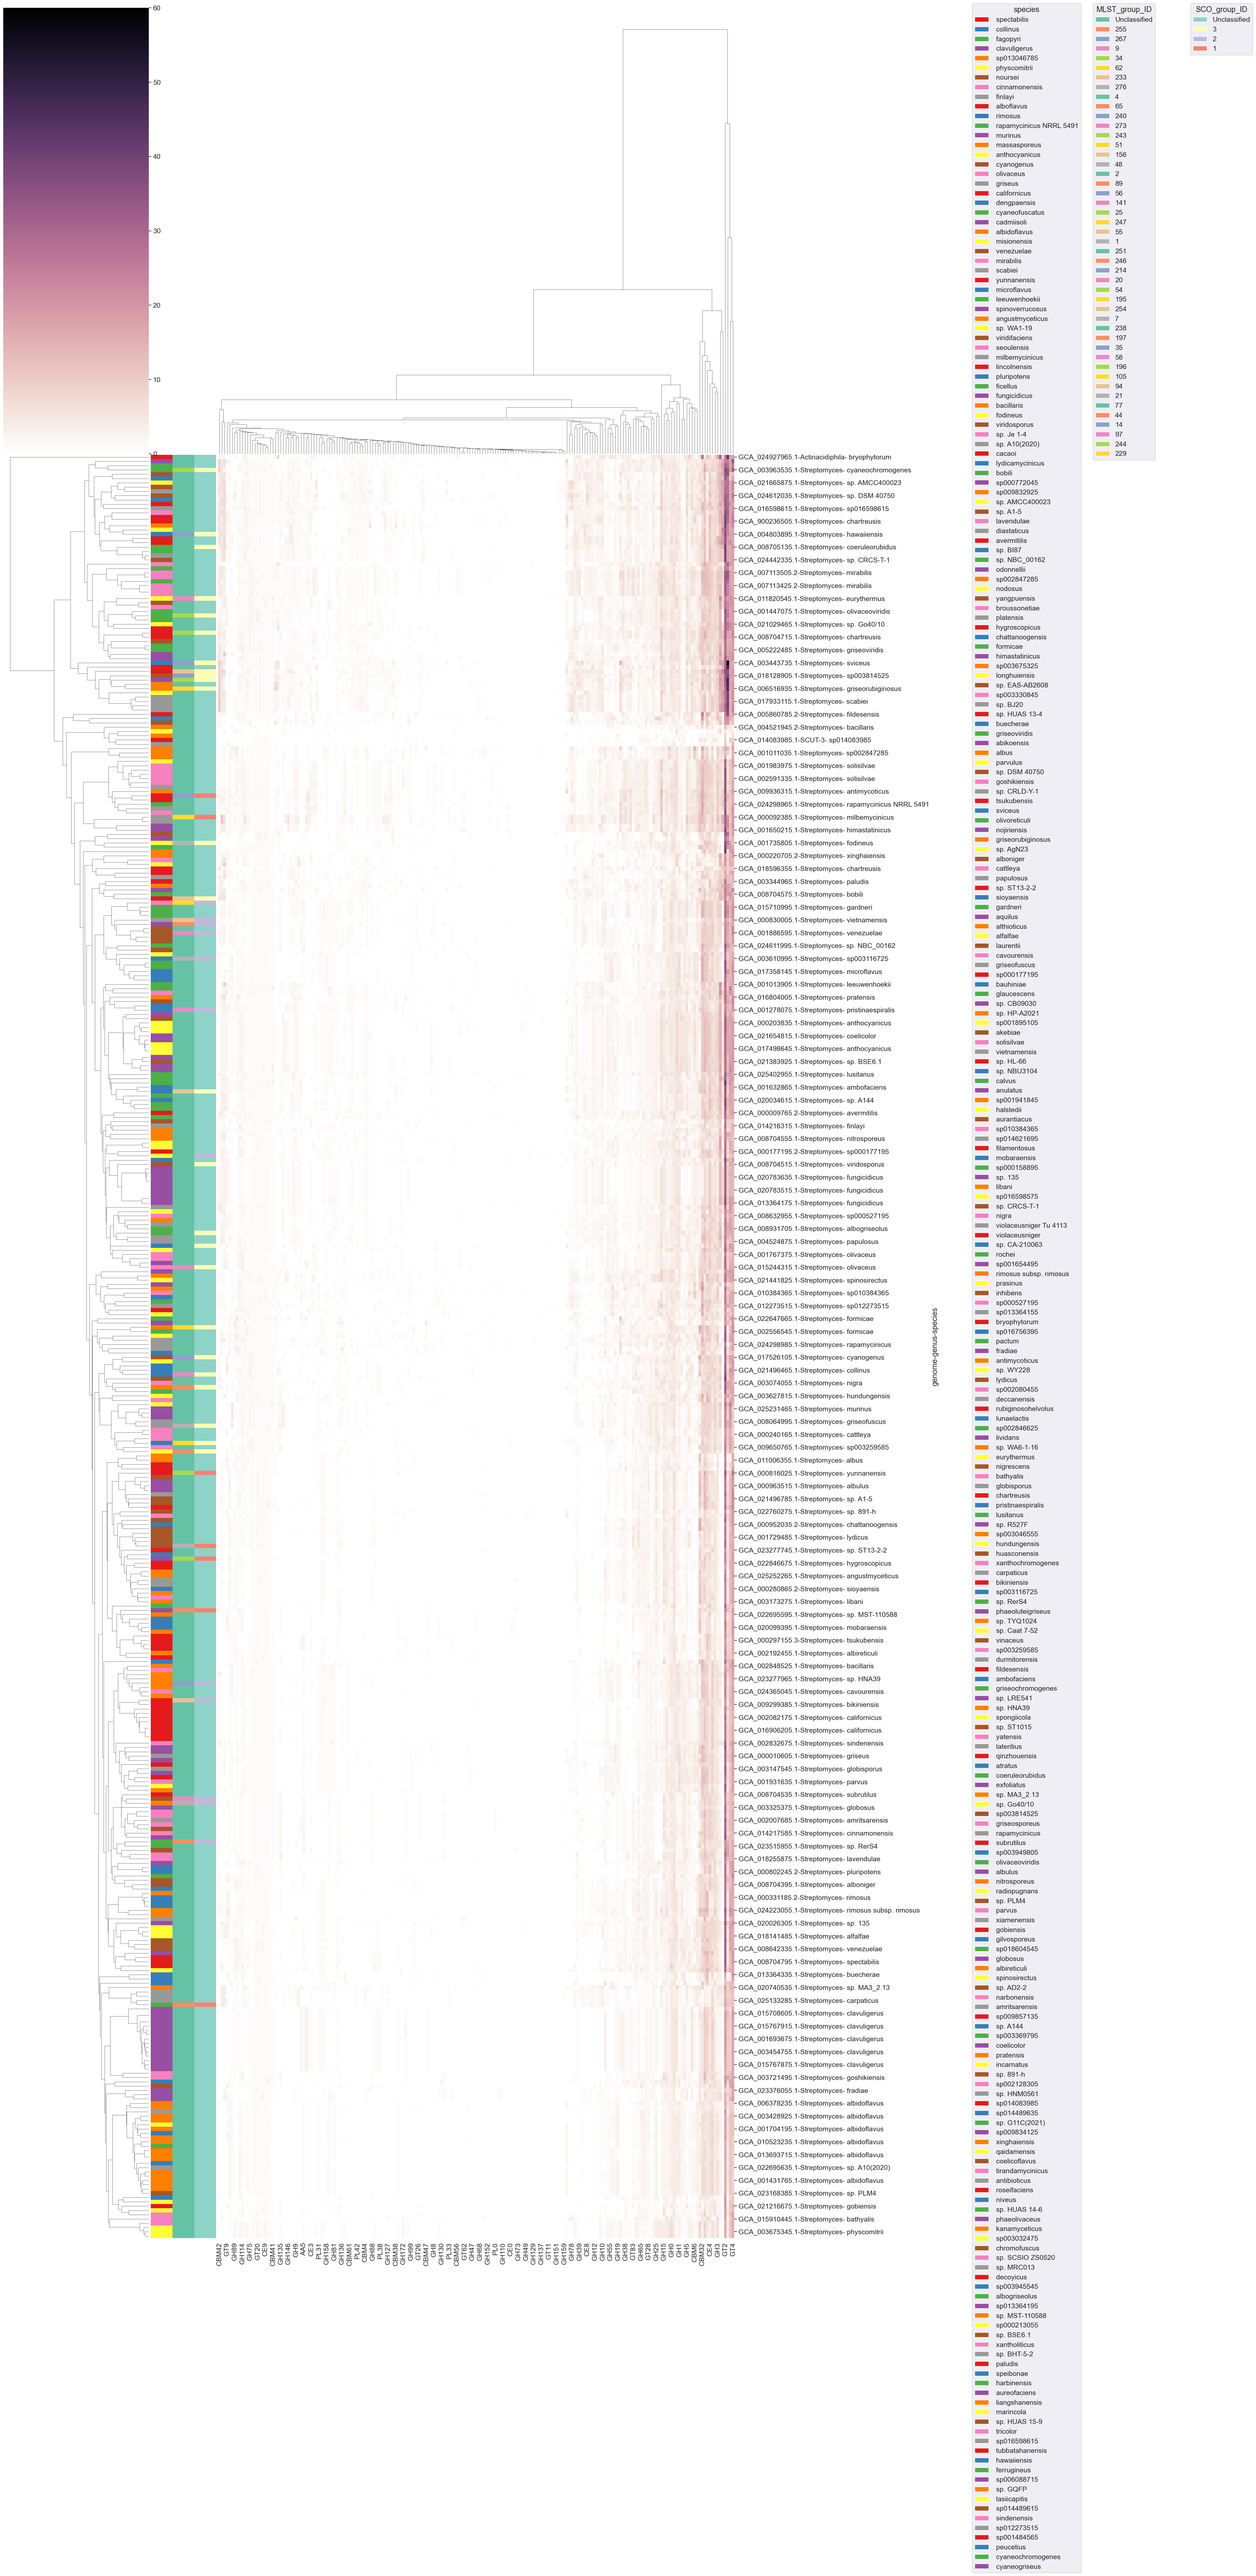

In [19]:
#4. Generating heatmap
heatmap_df["species"]=species_col 
heatmap_df["MLST_group_ID"]=mlst
heatmap_df["SCO_group_ID"]=sco

grp_series = heatmap_df.pop("species")
lut = dict(zip(grp_series.unique(), sns.color_palette("Set1", n_colors=len(set(species_col))))) #Same num colour as species column
row_colours = grp_series.map(lut)

#Row colours for MLST 
mlst_series = heatmap_df.pop("MLST_group_ID")
lut_mlst = dict(zip(mlst_series.unique(), sns.color_palette("Set2", n_colors=len(set(mlst))))) #Same num colour as species column
row_colours_mlst = mlst_series.map(lut_mlst)

#Row colours for SCO
sco_series = heatmap_df.pop("SCO_group_ID")
lut_sco = dict(zip(sco_series.unique(), sns.color_palette("Set3", n_colors=len(set(sco))))) #Same num colour as species column
row_colours_sco = sco_series.map(lut_sco)


#heatmap with colours being reversed so 0 is light and 10 is dark. cubhelix is the name of the colour scheme.
sns.set(font_scale=1.4)
heatmap = sns.clustermap(heatmap_df[:-2],
                         cmap=sns.cubehelix_palette(dark=1,light=0,reverse=True,as_cmap=True),
                         figsize=(30,70),
                         row_colors=[row_colours,row_colours_mlst,row_colours_sco])

#Gridspace +ing in other row_colours
heatmap.gs.update(left=.05,right=.8)
gs2=matplotlib.gridspec.GridSpec(1,1,left=.45)
ax2=heatmap.fig.add_subplot(gs2[0])
ax2.set_axis_off()


#Adding in legend
handles = [Patch(facecolor=lut[name]) for name in lut]
handles_mlst = [Patch(facecolor=lut_mlst[name]) for name in lut_mlst]
handles_sco = [Patch(facecolor=lut_sco[name]) for name in lut_sco]
first_legend=ax2.legend(handles,lut,title="species",bbox_transform=plt.gcf().transFigure,bbox_to_anchor=(1.1,1),loc="upper center")
ax2.add_artist(first_legend) 
second_legend=ax2.legend(handles_mlst,lut_mlst,title="MLST_group_ID",bbox_transform=plt.gcf().transFigure,bbox_to_anchor=(1.2,1),loc="upper center")
ax2.add_artist(second_legend) 
ax2.legend(handles_sco,lut_sco,title="SCO_group_ID",bbox_transform=plt.gcf().transFigure,bbox_to_anchor=(1.3,1),loc="upper center")


#Saving heatmap
heatmap.savefig("../data/heatmap_data/heatmap.svg",bbox_inches="tight") #Save as svg file (vector)
heatmap.savefig("../data/heatmap_data/heatmap.png",bbox_inches="tight") #Save as png file (JPEG for putting in results)
heatmap

## 7. Results: Frequency of CAZy families
<a id="core-cazomes"></a>
***Each line below refers to a seperate code block.***

1. Loop to find CAZy families which appear in every genome
2. Generate a boxplot of this frequency data
3. Dictionary of family frequency within each species
4. Statistical analysis of species dictionary 

In [20]:
#1. All CAZy families which appear in all genomes
core_cazomes = {}

for col in heatmap_df.columns:
    if 0 not in heatmap_df[col].to_list(): #Convert column to list
        mean=np.mean(heatmap_df[col])
        sd=np.std(heatmap_df[col])
        core_cazomes[col]={"mean":mean,"std":sd}
core_cazomes


{'CBM32': {'mean': 8.028708133971293, 'std': 3.695871064361359},
 'GH0': {'mean': 4.011961722488039, 'std': 1.309644196711385},
 'GH13': {'mean': 13.535885167464114, 'std': 3.60288352171203},
 'GH3': {'mean': 5.739234449760765, 'std': 2.514349514470588},
 'GT2': {'mean': 25.669856459330145, 'std': 6.152845879720009},
 'GT4': {'mean': 16.44736842105263, 'std': 3.7190001309913687}}

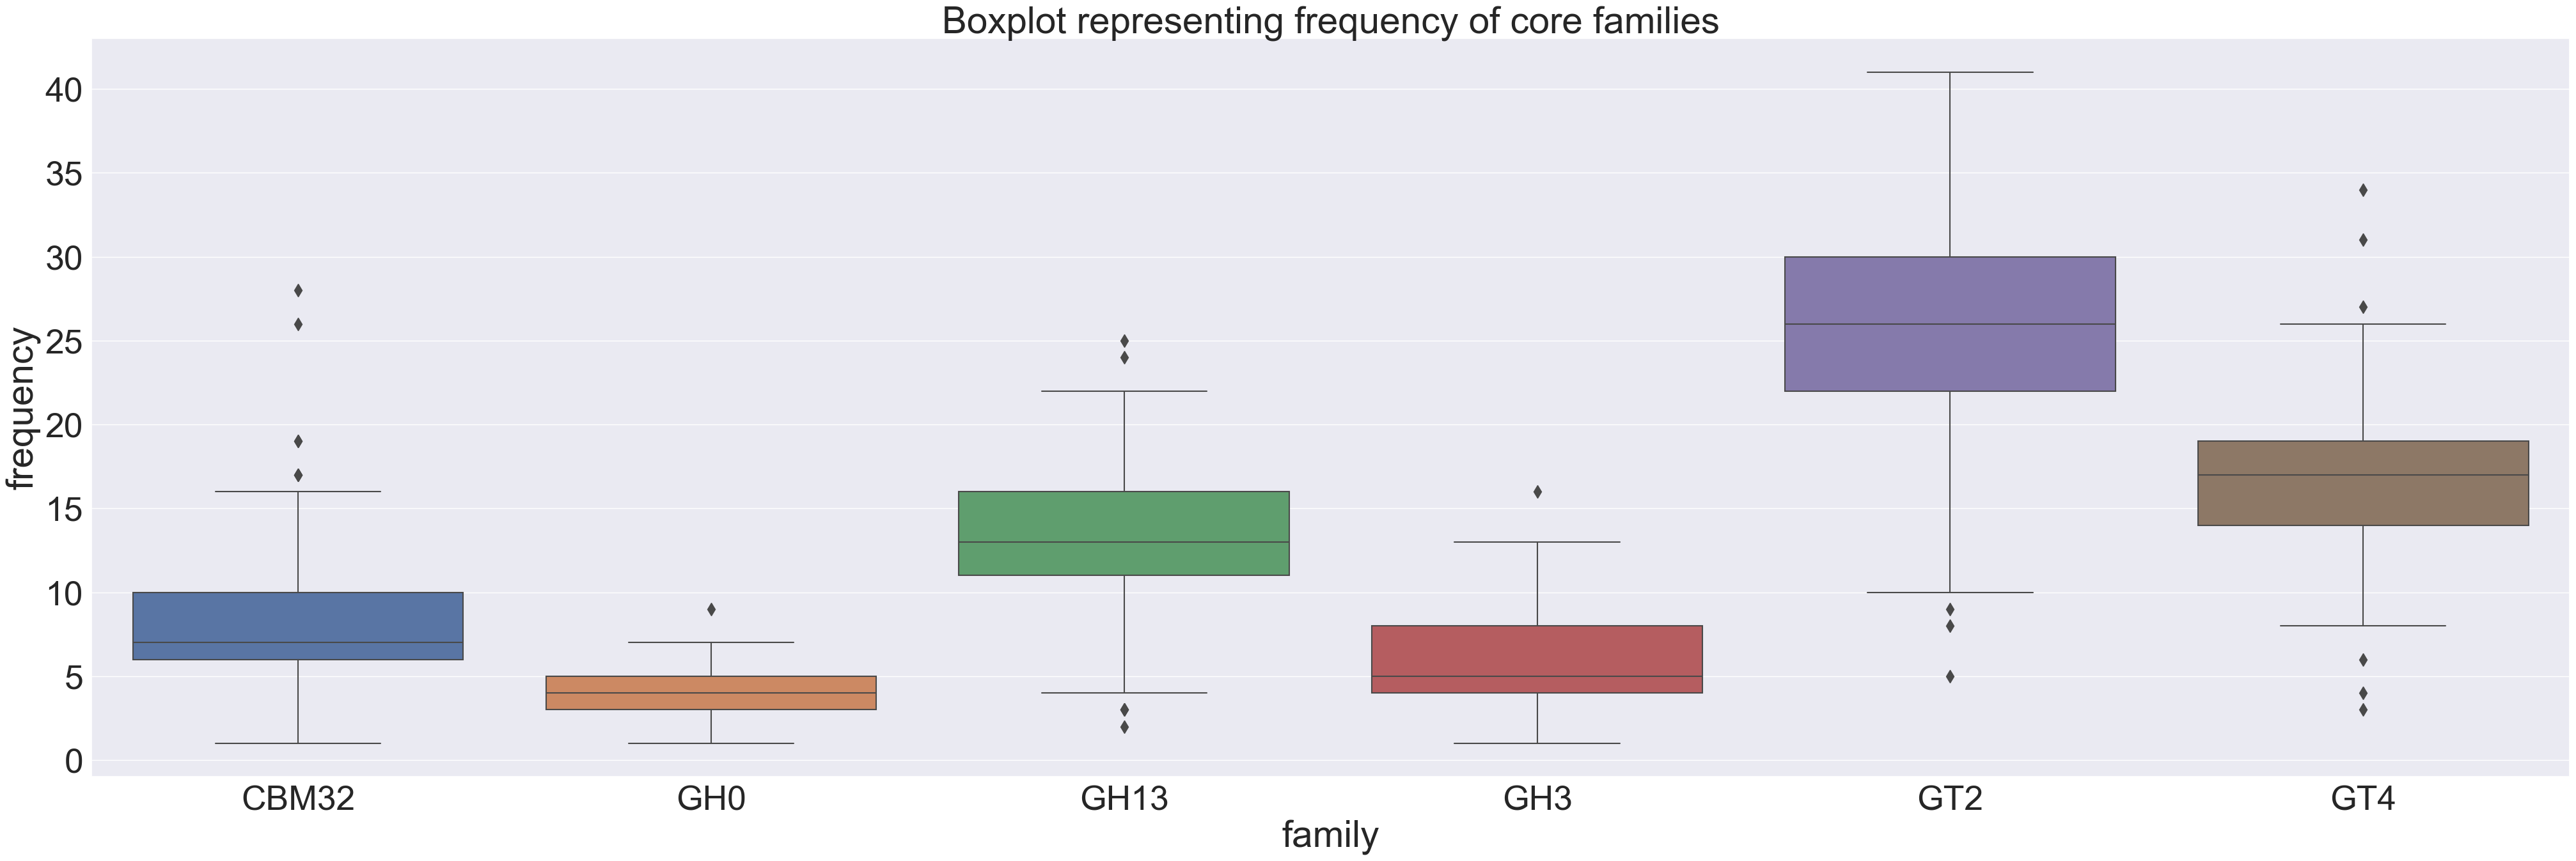

In [21]:
#2. Boxplot of family frequency data

#New df with 1. col = cazy fam col2 = freq fam
core_cazy_fam_freq = []

for fam in core_cazomes:
    freqs = heatmap_df[fam]
    for freq in freqs: #String don't use s if list then go ahead
        core_cazy_fam_freq.append([fam,freq]) #Adding in data

#boxplot
boxplot_data = pd.DataFrame(core_cazy_fam_freq,columns=["family","freq"]) 
sns.set(rc={"figure.figsize":(50,15)},font_scale=3.5) #(x,y)
ax = sns.boxplot(x=boxplot_data["family"],y=boxplot_data["freq"], fliersize=10) #Fix this fliernumber. 
ax.set(ylabel="frequency")
ax.set_title("Boxplot representing frequency of core families")

#Saving boxplot
plt.savefig("../data/jupyter_results/boxplot.png",bbox_inches="tight")

In [22]:
#3. Dictionary of family frequency in each species
species_dict = {}

for i in range(len(heatmap_df)):
    row = heatmap_df.iloc[i] 
    species = row.name[-1]
    for fam in core_cazomes:
        freq = row[fam] #Freq first fam
        try:
            species_dict[species]
        except KeyError:
            species_dict[species]={} #If keyerror is raised then species goes into empty dict.
        try:
            species_dict[species][fam].append(freq) #drop down list. Add to list
        except KeyError:
            species_dict[species][fam]=[freq] #new [List]. If it didn't exist put here.
species_dict 
#dict={species:{fam:[list]}}

{' spectabilis': {'CBM32': [7, 7],
  'GH0': [5, 5],
  'GH13': [12, 12],
  'GH3': [5, 5],
  'GT2': [31, 32],
  'GT4': [19, 19]},
 ' collinus': {'CBM32': [5, 5, 5],
  'GH0': [4, 3, 4],
  'GH13': [21, 17, 13],
  'GH3': [5, 5, 5],
  'GT2': [31, 34, 31],
  'GT4': [19, 18, 19]},
 ' fagopyri': {'CBM32': [12],
  'GH0': [5],
  'GH13': [17],
  'GH3': [7],
  'GT2': [26],
  'GT4': [16]},
 ' clavuligerus': {'CBM32': [5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 6],
  'GH0': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
  'GH13': [9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9],
  'GH3': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  'GT2': [17, 19, 17, 19, 19, 19, 19, 16, 19, 14, 18, 19, 19, 19, 18],
  'GT4': [16, 17, 17, 16, 19, 17, 17, 17, 17, 16, 17, 18, 17, 19, 17]},
 ' sp013046785': {'CBM32': [7],
  'GH0': [5],
  'GH13': [17],
  'GH3': [4],
  'GT2': [31],
  'GT4': [17]},
 ' physcomitrii': {'CBM32': [3, 3, 3],
  'GH0': [7, 7, 7],
  'GH13': [11, 11, 11],
  'GH3': [6, 6, 6],
  'GT2': [17, 16, 16],
 

In [23]:
#4. Creating df of species cazy family, mean and sd by iterating over the above code block/dictionary
#Use csv file here to make matrix plot in raw graphs

species_list=[]

for species in species_dict:
    for fam in core_cazomes:
        fam_mean=round(np.mean(species_dict[species][fam]),2)
        fam_sd=round(np.std(species_dict[species][fam]),2)
        #species, fam, mean and sd
        row_list = [species,fam,fam_mean,fam_sd]
        species_list.append(row_list)
    #Getting sample size for species (not core_cazomes)
    num_of_genomes=0
    for i in range(len(heatmap_df)):
        row_species=heatmap_df.iloc[i].name[-1]
        if row_species == species:
            num_of_genomes+=1
    species_list.append([species,"sample size",num_of_genomes, "-"]) 

core_fam_freqs_df=pd.DataFrame(species_list,columns=["species","fam","mean","sd"])
core_fam_freqs_df

csv_file = "../data/jupyter_results/core_fam_freqs_df.csv" #Saved to make matrix plot in "rawgraphs"
core_fam_freqs_df.to_csv(csv_file)

## 8. Summary table
<a id="summary-table"></a>
***Each line below refers to a seperate code block.***

1. Dictionary of CAZy families
2. CAZy family table
3. Mean CAZy family
4. SD CAZy family
5. Range CAZy family
***
6. Function for finding number of CAZymes per genome aka CAZomes
7. Dictionary for getnumcazymes function output data
8. 2nd dictionary for CAZomes
9. CAZomes table
10. CAZomes mean
11. CAZomes SD
12. CAZomes range

In [24]:
#1. Creating a dictionary key genomeic accession and value is cazy families
#Dictionary order is species with list counts of cazy families in each genome

cazy_fam_count_dict = {}

for i in range(len(heatmap_df)):
    row = heatmap_df.iloc[i]
    family_count = 0
    for col in heatmap_df.columns:
        if row[col]>1:
            family_count +=1
    species=row.name[-1] #For mean per species
    try:
        cazy_fam_count_dict[species] #Checking if it is here = species
    except KeyError:
        cazy_fam_count_dict[species]={"counts":[]}
    cazy_fam_count_dict[species]["counts"].append(family_count)
cazy_fam_count_dict

{' spectabilis': {'counts': [38, 38]},
 ' collinus': {'counts': [42, 39, 38]},
 ' fagopyri': {'counts': [50]},
 ' clavuligerus': {'counts': [34,
   34,
   34,
   33,
   34,
   34,
   34,
   34,
   34,
   30,
   34,
   34,
   35,
   34,
   35]},
 ' sp013046785': {'counts': [44]},
 ' physcomitrii': {'counts': [40, 41, 40]},
 ' noursei': {'counts': [33, 29]},
 ' cinnamonensis': {'counts': [34]},
 ' finlayi': {'counts': [37]},
 ' alboflavus': {'counts': [51]},
 ' rimosus': {'counts': [36, 36, 36]},
 ' rapamycinicus NRRL 5491': {'counts': [61]},
 ' murinus': {'counts': [42, 42, 42]},
 ' massasporeus': {'counts': [34]},
 ' anthocyanicus': {'counts': [54, 56, 56, 54, 56, 54]},
 ' cyanogenus': {'counts': [46]},
 ' olivaceus': {'counts': [41, 45, 46]},
 ' griseus': {'counts': [40]},
 ' californicus': {'counts': [32, 32, 32, 28, 31, 31, 32, 32]},
 ' dengpaensis': {'counts': [38]},
 ' cyaneofuscatus': {'counts': [41, 42]},
 ' cadmiisoli': {'counts': [52]},
 ' albidoflavus': {'counts': [38,
   35,

In [25]:
#2. Turn into table
cazome_summary_data=[]

for species in cazy_fam_count_dict:
    mean=np.mean(cazy_fam_count_dict[species]["counts"])
    sd=np.std(cazy_fam_count_dict[species]["counts"])
    num_of_genomes=len(cazy_fam_count_dict[species]["counts"]) #num of counts = num of genomes
    cazome_summary_data.append([species,mean,sd,num_of_genomes])

cazome_summary_df=pd.DataFrame(cazome_summary_data,columns=["species","mean","sd","num_of_genomes"])
cazome_summary_df

#Save as csv and add to results


species       mean        sd  num_of_genomes
0           spectabilis  38.000000  0.000000               2
1              collinus  39.666667  1.699673               3
2              fagopyri  50.000000  0.000000               1
3          clavuligerus  33.800000  1.107550              15
4           sp013046785  44.000000  0.000000               1
..                  ...        ...       ...             ...
260         sp012273515  55.000000  0.000000               1
261         sp001484565  62.000000  0.000000               1
262           peucetius  49.000000  0.000000               1
263   cyaneochromogenes  67.000000  0.000000               1
264       cyaneogriseus  48.000000  0.000000               1

[265 rows x 4 columns]

In [26]:
#3. State mean of the families
np.mean(cazome_summary_df["mean"])

45.10611260856543

In [27]:
#4. State sd of the families
np.std(cazome_summary_df["sd"])

1.5356190807820265

In [28]:
#5. Range of family counts
all_cazy_fam_counts=[]

for species in cazy_fam_count_dict:
    all_cazy_fam_counts += cazy_fam_count_dict[species]["counts"]
print(f"Highest number of cazy families is {max(all_cazy_fam_counts)} and lowest number of cazy families is {min(all_cazy_fam_counts)}")

Highest number of cazy families is 82 and lowest number of cazy families is 11


In [29]:
#6. Creating function get number of cazymes predicted by dbcan
def getnumcazymes(dbcan_output_path):
    """Load df in, filter dataframe to drop tools of 1. and drop EC number column. Use processed
    dbcan function which i will have to load in which will result in new_hmmer etc. Get consensus aka total.
    Use counter function to frequences of families and return that function."""
      
    #Loading in df, drop column
    df = pd.read_table(dbcan_output_path).drop(columns=["EC#"])  #Load dataframe and drop EC column
    df_filtered = df[df['#ofTools'] != 1] #Dropping all #oftools column which = 1 for consensous reasons
                                           
    #Function "process_dbcan_output" called in and used on HMMER,eCAMI and DIAMOND
    df_filtered = process_dbcan_output(df_filtered,"HMMER")
    df_filtered = process_dbcan_output(df_filtered,"eCAMI")
    df_filtered = process_dbcan_output(df_filtered,"DIAMOND")
    
                                               
    #Consensus data
    number_of_cazymes=0 

    for row_index in range(len(df_filtered)): 
        row = df_filtered.iloc[row_index] 
        hmmer_output = set(row["new_HMMER"].split("+"))
        ecami_output = set(row["new_eCAMI"].split("+"))
        diamond_output = set(row["new_DIAMOND"].split("+"))

        all_consensus = list(hmmer_output & diamond_output & ecami_output)
        hmmer_diamond_consensus = list(hmmer_output & diamond_output )
        hmmer_ecami_consensus = list(hmmer_output & ecami_output)
        diamond_ecami_consensus = list(diamond_output & ecami_output)

        consensus_fams = list(set(all_consensus + hmmer_diamond_consensus + hmmer_ecami_consensus + diamond_ecami_consensus))
        consensus_fams = [fams for fams in consensus_fams if len(fams)>0] 
        if len(consensus_fams) > 0: 
                number_of_cazymes += 1
                                
    return number_of_cazymes  

In [30]:
#7. Creating dictionary for getnumcazymes output data
cazyme_count_dict = {}

for dir_path in dbcan_directories:
    genomeID = "_".join(dir_path.name.split("_")[:2]).replace(".faa","") #Join function using split and getting rid .faa
    overview_path = dir_path/"overview.txt"
    count_freq = getnumcazymes(overview_path)
    cazyme_count_dict[genomeID] = count_freq
    
cazyme_count_dict #accession, cazymes per genome. 


/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_24243/1226899305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_df[f'new_{tool}'] = new_processed_data #create string with tool name (eCAMI,HMMER,DIAMOND)
/var/folders/pv/g8yqw8956x74zl347s0mvdgw0000gn/T/ipykernel_2

{'GCA_007363395.1': 217,
 'GCA_021496465.1': 224,
 'GCA_009498275.1': 247,
 'GCA_015767855.1': 168,
 'GCA_013046785.1': 234,
 'GCA_000827005.1': 202,
 'GCA_001704275.1': 205,
 'GCA_014217585.1': 191,
 'GCA_014216315.1': 181,
 'GCA_002189675.2': 238,
 'GCA_006229535.1': 202,
 'GCA_024298965.1': 337,
 'GCA_025231465.1': 205,
 'GCA_014701095.1': 221,
 'GCA_000739105.1': 282,
 'GCA_017526105.1': 245,
 'GCA_001767375.1': 198,
 'GCA_000010605.1': 216,
 'GCA_016906265.1': 174,
 'GCA_002946835.1': 197,
 'GCA_001693675.1': 174,
 'GCA_904440635.1': 230,
 'GCA_003261055.1': 262,
 'GCA_001431765.1': 158,
 'GCA_013423905.1': 239,
 'GCA_008642275.1': 168,
 'GCA_007113505.2': 376,
 'GCA_017933255.1': 327,
 'GCA_000816025.1': 219,
 'GCA_013364315.1': 232,
 'GCA_001013905.1': 264,
 'GCA_013009255.1': 335,
 'GCA_019933235.1': 168,
 'GCA_000331185.2': 206,
 'GCA_004104485.1': 205,
 'GCA_020535385.1': 168,
 'GCA_001888885.2': 227,
 'GCA_022846655.1': 177,
 'GCA_016467295.1': 209,
 'GCA_000092385.1': 413,


In [31]:
#8. 2nd dict key = species and values list[count of cazymes with 1 count per genome]
cazome_count_dict = {}

for i in range(len(heatmap_df)):
    row = heatmap_df.iloc[i] #Data from heatmap_df. want genomes in order
    genome=row.name[0]  
    species=row.name[-1] #For mean per species
    count=cazyme_count_dict[genome]
    try:
        cazome_count_dict[species] #Checking if it is here = species
    except KeyError:
        cazome_count_dict[species]={"counts":[]}
    cazome_count_dict[species]["counts"].append(count)
cazome_count_dict


{' spectabilis': {'counts': [217, 216]},
 ' collinus': {'counts': [224, 230, 203]},
 ' fagopyri': {'counts': [247]},
 ' clavuligerus': {'counts': [168,
   174,
   171,
   170,
   181,
   174,
   171,
   169,
   172,
   151,
   171,
   173,
   175,
   181,
   175]},
 ' sp013046785': {'counts': [234]},
 ' physcomitrii': {'counts': [202, 199, 199]},
 ' noursei': {'counts': [205, 190]},
 ' cinnamonensis': {'counts': [191]},
 ' finlayi': {'counts': [181]},
 ' alboflavus': {'counts': [238]},
 ' rimosus': {'counts': [202, 206, 203]},
 ' rapamycinicus NRRL 5491': {'counts': [337]},
 ' murinus': {'counts': [205, 205, 209]},
 ' massasporeus': {'counts': [221]},
 ' anthocyanicus': {'counts': [282, 298, 300, 283, 296, 283]},
 ' cyanogenus': {'counts': [245]},
 ' olivaceus': {'counts': [198, 227, 247]},
 ' griseus': {'counts': [216]},
 ' californicus': {'counts': [174, 177, 179, 169, 176, 169, 177, 179]},
 ' dengpaensis': {'counts': [197]},
 ' cyaneofuscatus': {'counts': [230, 230]},
 ' cadmiisoli'

In [32]:
#9. Turn into table
cazome_count_summary_data=[]

for species in cazome_count_dict:
    mean=np.mean(cazome_count_dict[species]["counts"])
    sd=np.std(cazome_count_dict[species]["counts"])
    num_of_genomes=len(cazome_count_dict[species]["counts"]) #num of counts = num of genomes
    cazome_count_summary_data.append([species,mean,sd,num_of_genomes])

cazome_count_summary_df=pd.DataFrame(cazome_count_summary_data,columns=["species","mean","sd","num_of_genomes"])
cazome_count_summary_df

#Save as csv and add to results

species        mean         sd  num_of_genomes
0           spectabilis  216.500000   0.500000               2
1              collinus  219.000000  11.575837               3
2              fagopyri  247.000000   0.000000               1
3          clavuligerus  171.733333   6.637938              15
4           sp013046785  234.000000   0.000000               1
..                  ...         ...        ...             ...
260         sp012273515  246.000000   0.000000               1
261         sp001484565  317.000000   0.000000               1
262           peucetius  233.000000   0.000000               1
263   cyaneochromogenes  359.000000   0.000000               1
264       cyaneogriseus  229.000000   0.000000               1

[265 rows x 4 columns]

In [33]:
#10. State mean of the cazomes
np.mean(cazome_count_summary_df["mean"])

231.6641599281222

In [34]:
#11. State sd of the cazomes
np.std(cazome_count_summary_df["sd"])

8.585011880551741

In [35]:
#12. Range of cazome counts
all_cazome_counts=[]

for species in cazome_count_dict:
    all_cazome_counts += cazome_count_dict[species]["counts"]
print(f"Highest number of cazy families is {max(all_cazome_counts)} and lowest number of cazy families is {min(all_cazome_counts)}")

Highest number of cazy families is 415 and lowest number of cazy families is 53


## 9. Preparing data for PCA plot 
<a id="pca-plot"></a>

***Each line below refers to a seperate code block.***
1. Duplicating a copy of heatmap_df for PCA analysis
2. Adding in second species column called sebastian
3. Select all data besides Sebastian 
4. Scaled the data to facilitate comparing varibles across the data



In [36]:
# 1. Copying heatmap_df
pca_df=copy(heatmap_df) #alters a copy of heatmap_df now named pca_df
pca_df

AA10  AA3  AA4  AA5  AA7  \
genome          genus        species                                        
GCA_007363395.1 Streptomyces  spectabilis           5    2    0    1    0   
GCA_021496465.1 Streptomyces  collinus              3    1    0    0    0   
GCA_009498275.1 Streptomyces  fagopyri              3    2    0    0    1   
GCA_015767855.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_013046785.1 Streptomyces  sp013046785           3    1    0    0    0   
...                                               ...  ...  ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius             4    2    0    0    0   
GCA_015767915.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     4    4    0    0    0   
GCA_001278095.1 Streptomyces  bacillaris            4    2    0    1    0   
GCA_000931445.1 Streptomyces  cyaneogriseus         5    1    0    0    0   

                                                 CBM0  CBM10  CBM11  CBM12  \
genome          genus        species                                         
GCA_007363395.1 Streptomyces  spectabilis           1      0      0      4   
GCA_021496465.1 Streptomyces  collinus              1      0      1      4   
GCA_009498275.1 Streptomyces  fagopyri              1      0      1      2   
GCA_015767855.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_013046785.1 Streptomyces  sp013046785           1      0      1      0   
...                                               ...    ...    ...    ...   
GCA_025854275.1 Streptomyces  peucetius             1      0      1      2   
GCA_015767915.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_003963535.1 Streptomyces  cyaneochromogenes     1      0      1      2   
GCA_001278095.1 Streptomyces  bacillaris            1      0      1      3   
GCA_000931445.1 Streptomyces  cyaneogriseus         1      0      0      3   

                                                 CBM13  ...  PL31  PL33  PL38  \
genome          genus        species                    ...                     
GCA_007363395.1 Streptomyces  spectabilis            5  ...     1     0     1   
GCA_021496465.1 Streptomyces  collinus               8  ...     1     0     1   
GCA_009498275.1 Streptomyces  fagopyri              11  ...     1     0     1   
GCA_015767855.1 Streptomyces  clavuligerus          10  ...     1     0     1   
GCA_013046785.1 Streptomyces  sp013046785           16  ...     1     0     1   
...                                                ...  ...   ...   ...   ...   
GCA_025854275.1 Streptomyces  peucetius             14  ...     0     0     0   
GCA_015767915.1 Streptomyces  clavuligerus          10  ...     1     0     1   
GCA_003963535.1 Streptomyces  cyaneochromogenes     34  ...     0     0     0   
GCA_001278095.1 Streptomyces  bacillaris             4  ...     1     0     0   
GCA_000931445.1 Streptomyces  cyaneogriseus          9  ...     0     0     0   

                                                 PL4  PL41  PL42  PL6  PL7  \
genome          genus        species                                         
GCA_007363395.1 Streptomyces  spectabilis          0     0     0    0    0   
GCA_021496465.1 Streptomyces  collinus             0     0     0    0    0   
GCA_009498275.1 Streptomyces  fagopyri             0     0     0    0    1   
GCA_015767855.1 Streptomyces  clavuligerus         0     0     0    0    0   
GCA_013046785.1 Streptomyces  sp013046785          0     0     0    0    1   
...                                              ...   ...   ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius            0     0     1    0    0   
GCA_015767915.1 Streptomyces  clavuligerus         0     0     0    0    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes    1     0     1    0    1   
GCA_001278095.1 Streptomyces  bacillaris           0     0     1    0    0   
GCA_000931445.1 Streptomyces  cyaneogriseu

In [37]:
# 2. Add second species column, second column will be called Sebasitan (Sebastian = GTDB)
pca_df['Sebastian'] = species_col
pca_df['mlst'] = mlst
pca_df['sco'] = sco
pca_df

AA10  AA3  AA4  AA5  AA7  \
genome          genus        species                                        
GCA_007363395.1 Streptomyces  spectabilis           5    2    0    1    0   
GCA_021496465.1 Streptomyces  collinus              3    1    0    0    0   
GCA_009498275.1 Streptomyces  fagopyri              3    2    0    0    1   
GCA_015767855.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_013046785.1 Streptomyces  sp013046785           3    1    0    0    0   
...                                               ...  ...  ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius             4    2    0    0    0   
GCA_015767915.1 Streptomyces  clavuligerus          5    2    0    1    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     4    4    0    0    0   
GCA_001278095.1 Streptomyces  bacillaris            4    2    0    1    0   
GCA_000931445.1 Streptomyces  cyaneogriseus         5    1    0    0    0   

                                                 CBM0  CBM10  CBM11  CBM12  \
genome          genus        species                                         
GCA_007363395.1 Streptomyces  spectabilis           1      0      0      4   
GCA_021496465.1 Streptomyces  collinus              1      0      1      4   
GCA_009498275.1 Streptomyces  fagopyri              1      0      1      2   
GCA_015767855.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_013046785.1 Streptomyces  sp013046785           1      0      1      0   
...                                               ...    ...    ...    ...   
GCA_025854275.1 Streptomyces  peucetius             1      0      1      2   
GCA_015767915.1 Streptomyces  clavuligerus          1      0      0      2   
GCA_003963535.1 Streptomyces  cyaneochromogenes     1      0      1      2   
GCA_001278095.1 Streptomyces  bacillaris            1      0      1      3   
GCA_000931445.1 Streptomyces  cyaneogriseus         1      0      0      3   

                                                 CBM13  ...  PL4  PL41  PL42  \
genome          genus        species                    ...                    
GCA_007363395.1 Streptomyces  spectabilis            5  ...    0     0     0   
GCA_021496465.1 Streptomyces  collinus               8  ...    0     0     0   
GCA_009498275.1 Streptomyces  fagopyri              11  ...    0     0     0   
GCA_015767855.1 Streptomyces  clavuligerus          10  ...    0     0     0   
GCA_013046785.1 Streptomyces  sp013046785           16  ...    0     0     0   
...                                                ...  ...  ...   ...   ...   
GCA_025854275.1 Streptomyces  peucetius             14  ...    0     0     1   
GCA_015767915.1 Streptomyces  clavuligerus          10  ...    0     0     0   
GCA_003963535.1 Streptomyces  cyaneochromogenes     34  ...    1     0     1   
GCA_001278095.1 Streptomyces  bacillaris             4  ...    0     0     1   
GCA_000931445.1 Streptomyces  cyaneogriseus          9  ...    0     0     0   

                                                 PL6  PL7  PL8  PL9  \
genome          genus        species                                  
GCA_007363395.1 Streptomyces  spectabilis          0    0    2    0   
GCA_021496465.1 Streptomyces  collinus             0    0    1    0   
GCA_009498275.1 Streptomyces  fagopyri             0    1    0    0   
GCA_015767855.1 Streptomyces  clavuligerus         0    0    1    0   
GCA_013046785.1 Streptomyces  sp013046785          0    1    1    0   
...                                              ...  ...  ...  ...   
GCA_025854275.1 Streptomyces  peucetius            0    0    2    2   
GCA_015767915.1 Streptomyces  clavuligerus         0    0    1    0   
GCA_003963535.1 Streptomyces  cyaneochromogenes    0    1    1    1   
GCA_001278095.1 Streptomyces  bacillaris           0    0    1    0   
GCA_000931445.1 Streptomyces  cyaneogriseus        1    1    1    0   

                                                          Sebastian

In [38]:
# 3. Retrieve the number of families in the df
nComp = len(list(pca_df.columns)[:-3]) # select all column names that are families and ignore the final 'Group' column
nComp

202

In [39]:
#4. Scaled the data to facilitate comparing varibles across the data
scaler = StandardScaler()  # creates an instance of the scaler object
families=list(pca_df.columns[:-3])

scaler.fit(pca_df.loc[:,families])  # fit our data of CAZy fam freqs to the standard scaler
X_scaled = scaler.transform(pca_df.loc[:,families])    #(df.loc[:, df.columns!='Sebastian'])

pca = PCA(n_components=nComp)  # runs PCA
pca.fit(X_scaled)  # fit our PCA to our scale called X_scaled

PCA(n_components=202)

### 10. Cumulative explained variance
<a id="cev"></a>
***Each line below refers to a seperate code block.***
1. Calclating cumulative explained variance (variance for each PC)
2. Plotting cumulative explained variance
3. Capturing 95% diversity within the dataset
4. Determining how many principal components (PCs) needed to capture 100% diversity
***

Each PC (princpal component) captures a different amount of diversity in the original dataset.

We can check how much diversity in the original dataset is captured by each PC, **and** we can check how much of the overall diversity in the dataset is captured by our PCA.

In [40]:
#1. Calculating cumulative explained variance
cumExpVar = np.cumsum(pca.explained_variance_ratio_)
cumExpVar # cumulativ explained varaince

array([0.17462664, 0.23335822, 0.2828842 , 0.32224903, 0.3528722 ,
       0.37915045, 0.40160157, 0.42188663, 0.44141332, 0.4606972 ,
       0.47907133, 0.49565259, 0.5107401 , 0.52481551, 0.53760701,
       0.5500715 , 0.56226473, 0.57413981, 0.58525515, 0.59609788,
       0.60671641, 0.61672374, 0.6261117 , 0.63544206, 0.64448917,
       0.65321953, 0.66175191, 0.67007525, 0.67796409, 0.68574885,
       0.69345593, 0.70079168, 0.70802383, 0.71489924, 0.72165371,
       0.72835998, 0.73474788, 0.74106224, 0.74709496, 0.75290432,
       0.75866308, 0.76440981, 0.77005807, 0.77560949, 0.78095148,
       0.786242  , 0.7914317 , 0.79647604, 0.80147123, 0.80632139,
       0.81108736, 0.81576742, 0.82032473, 0.82484092, 0.82915949,
       0.83332768, 0.83746342, 0.84148673, 0.84545821, 0.84928955,
       0.85303808, 0.85674684, 0.86040451, 0.86389142, 0.86730022,
       0.87066649, 0.87384197, 0.8769799 , 0.88006289, 0.88309261,
       0.88604249, 0.88893136, 0.89174364, 0.89447411, 0.89712

<div class="alert alert-block alert-danger">
Change tick size and mess with the graph a bit

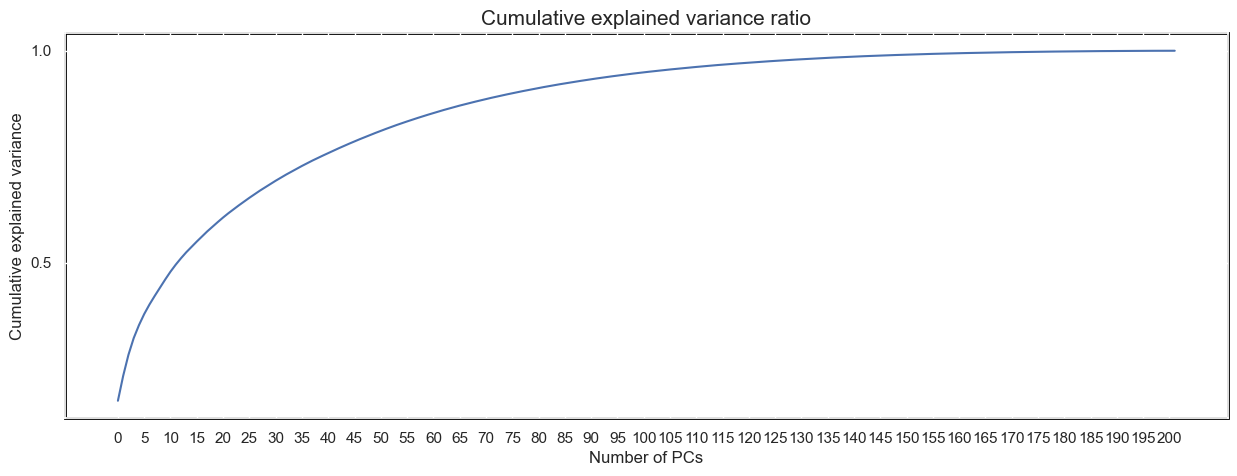

In [41]:
# 2. Plot the cumulative explained variance
fig = plt.figure(figsize=(15,5))
im = plt.plot(range(nComp), cumExpVar) 

# range(nComp) = x axis values == the number of PCs
# cumExpVar is the cumulative explained varaince
plt.xticks(np.arange(0,nComp,5),fontsize=11); #np.arrange(min val,values(PCs),max value)
plt.yticks(fontsize=11);
plt.xlabel('Number of PCs', fontsize=12);
plt.ylabel('Cumulative explained variance', fontsize=12);
plt.title("Cumulative explained variance ratio",fontsize=15)
ax = plt.gca(); 
ax.set_facecolor("white");
ax.patch.set_edgecolor('black');  #
ax.patch.set_linewidth("2");  #
plt.show;

#Save figure
plt.savefig("../data/jupyter_results/cumulative-explained-variance.png",bbox_inches="tight")

We can see that all variance in the original dataset is captured by our PCA, but we can also see we don't need all 101 PCs to capture the entirity of the variation.

We can check how many PCs we need to capture a threshold of varaition in our original dataset.

In [42]:
# 3. We want to capture at least 95% of the diveristy in the original dataset
threshold = 0.95
keepPC = [pc for pc in range(nComp) if cumExpVar[pc] >= threshold][0]
print(
    f"Number of features needed to explain {threshold * 100}% fraction of the total varaince is {keepPC}" 
)

Number of features needed to explain 95.0% fraction of the total varaince is 101


In [43]:
# 4. Check how many PCs we need to capture 100%
threshold = 1
keepPC = [pc for pc in range(nComp) if cumExpVar[pc] >= threshold][0]
print(
    f"Number of features needed to explain {threshold * 100}% fraction of the total varaince is {keepPC}" 
)

Number of features needed to explain 100% fraction of the total varaince is 200


### 11. Scree plot 
<a id="scree"></a>
We can visualise the diversity captured by each individual PC, rather than the cumulative effect.

This allows us to identify which PCs will be of interest for exploring and plotting.  

***Each line below refers to a seperate code block.***
1. Plotting scree plot  

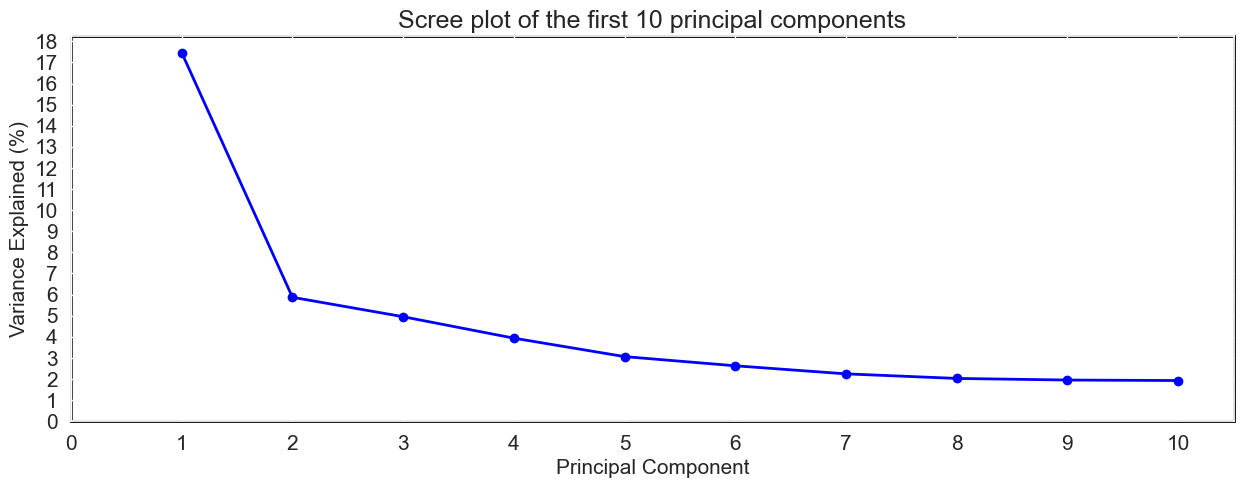

In [44]:
# 1. Plotting scree plot 
fig = plt.figure(figsize=(15,5)) 

pc_values = np.arange(10) + 1  # np.arange needs to have the same number of samples as plotted on the graph
plt.plot(pc_values, pca.explained_variance_ratio_[0:10]*100, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Variance Explained (%)', fontsize=15)
plt.title("Scree plot of the first 10 principal components",fontsize=18)
plt.xticks(np.arange(0,nComp,1), fontsize=15); #maybe add on ticks for all PCs? 0 is min. n.how many to give it and 1 is the max
plt.yticks(np.arange(0,19,1),fontsize=15) 
plt.xlim([0,10.5])#
ax = plt.gca() #
ax.set_facecolor("white") #
ax.patch.set_edgecolor('black')  #
ax.patch.set_linewidth("2")  #
plt.show;

#Save figure
plt.savefig("../data/jupyter_results/scree_plot.png",bbox_inches="tight")

`'o-'` - makes it a dot and line plot
PC1 always captures the most diversity in the dataset.

PC1-PC4 capture a large degree of the diversity in the dataset. Therefore, we will explore PC1 to PC4.

## 12. Analysing principal components (PCs)
<a id="analysing-pcs"></a>
***Each line below refers to a seperate code block.***
1. Function for comparing PCs
2. PCA plot of PC1 vs PC2 (GTDB)
3. PCA plot of PC1 vs PC2 (MLST)
4. PCA plot of PC1 vs PC2 (SCO)
***
The following code could be turned into a function.

Each time you run the code, the values that change are the indexes of the PCs (PC1 = 0, PC2 = 1, PC3 = 2 etc.)

Plot:
* 1 vs 2


***Each line below refers to a seperate code block.***
1. Function for plotting PCs 
2. Comparing PC 1 vs 3
3. Scaling data to compare PCs

In [45]:
#1. Function for comparing PCs
def compare_pcs(first_pc, second_pc,df, x_limits, y_limits, hue, figsize=None): 
    """Generate a scatter plot for the provided PCs
    
    :param first_pc: int, index of the first PC
    :param second_pc: int, index of the second PC
    :df: dataframe which PCA is performed on 
    :x_limits: x-axis limit annotation
    :y_limits: y-axis limit annotation
    :hue: name of column to colour code by
    
    Returns nothing
    """
    X_pca = pca.transform(X_scaled)  # facilitates comparing between the PCs

    if figsize is not None:
        plt.figure(figsize=figsize)
        
    # plot PC1 against PC2
    g = sns.scatterplot(
        x=X_pca[:,first_pc],  # PC1
        y=X_pca[:,second_pc],  # PC2
        data=df,  # dataframe containing the 'Group' columns
        hue=hue,  # name of the col in df, that we want to colour code the genomes by
        s=200,  # size of markers,
        style=hue,
    )
    g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
    g.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    
    plt.xlabel(f"PC{first_pc + 1} {round(100 * pca.explained_variance_ratio_[first_pc],2)}%")
    plt.ylabel(f"PC{second_pc + 1} {round(100 * pca.explained_variance_ratio_[second_pc],2)}%")
    plt.title(f"Comparing PC{first_pc + 1} vs PC{second_pc + 1}")

    
    #Annotation labels
    text=[] 
    for i,species in enumerate(species_col):
        if (X_pca[:,0][i]>=x_limits) or (X_pca[:,1][i]>=y_limits):
            new_text=plt.text(
                X_pca[:,0][i], #X coord
                X_pca[:,1][i], #Y coord
                species,#Label
                ha="center",
                va="center",
                fontsize=12
            )
            text.append(new_text)
    
    adjustText.adjust_text(text, arrowsprops=dict(arrowstyle='-', color='black')); #Makes names not overlap with markers
    
    #Legend
    plt.legend(loc='upper center', borderaxespad=0)
    sns.move_legend(g,"upper center",bbox_to_anchor=(0.45,-0.2),ncol=5,title=None,frameon=False) #g is plot object #bbox_to_anchor=(.5,1) used for more accurate placement
    plt.show;
    
    
    """Make the labels a variable rather than a set point"""

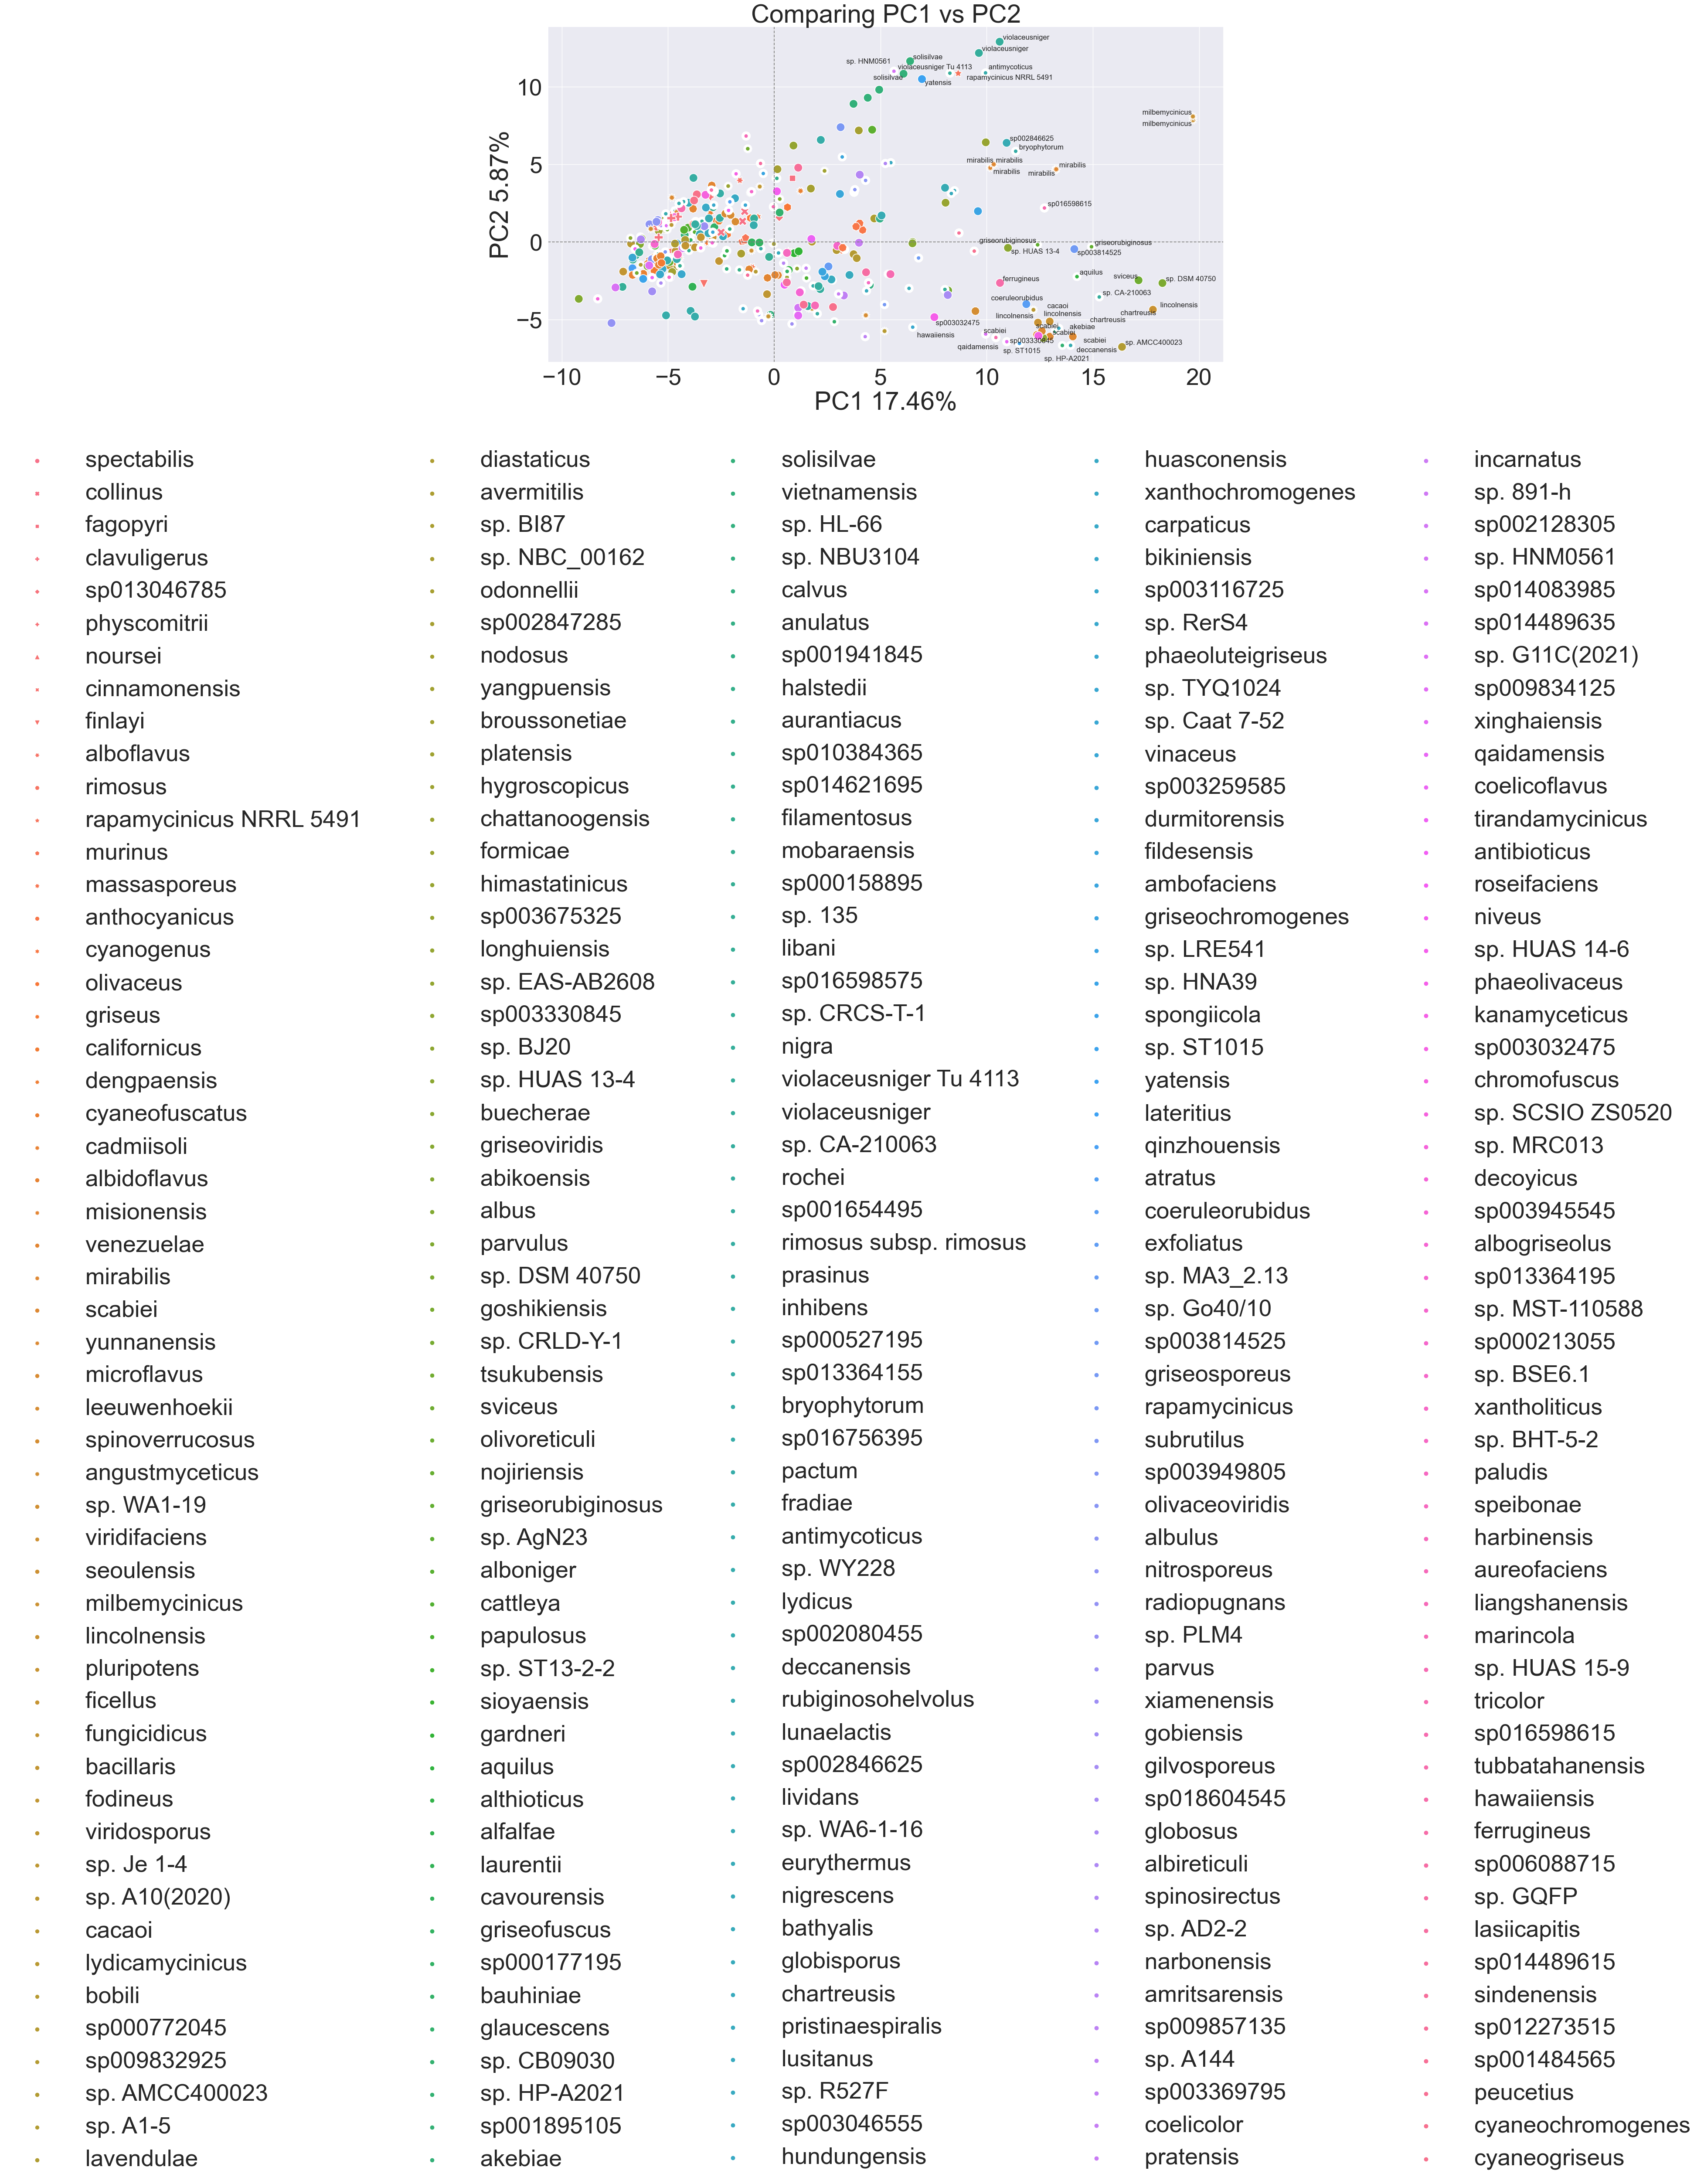

In [46]:
#2. plt pc1 vs pc2
#compare_pcs(first_pc,second_pc,x_lab,y_lab,figuresize)
#(first_pc, second_pc,df, x_limits, y_limits, hue, figsize=None):
compare_pcs(0, 1,pca_df, 10, 10,"Sebastian", figsize=(20,10))

#Save figure
plt.savefig("../data/jupyter_results/pca_plot_PC1vsPC2_by_GDTB.png",bbox_inches="tight")

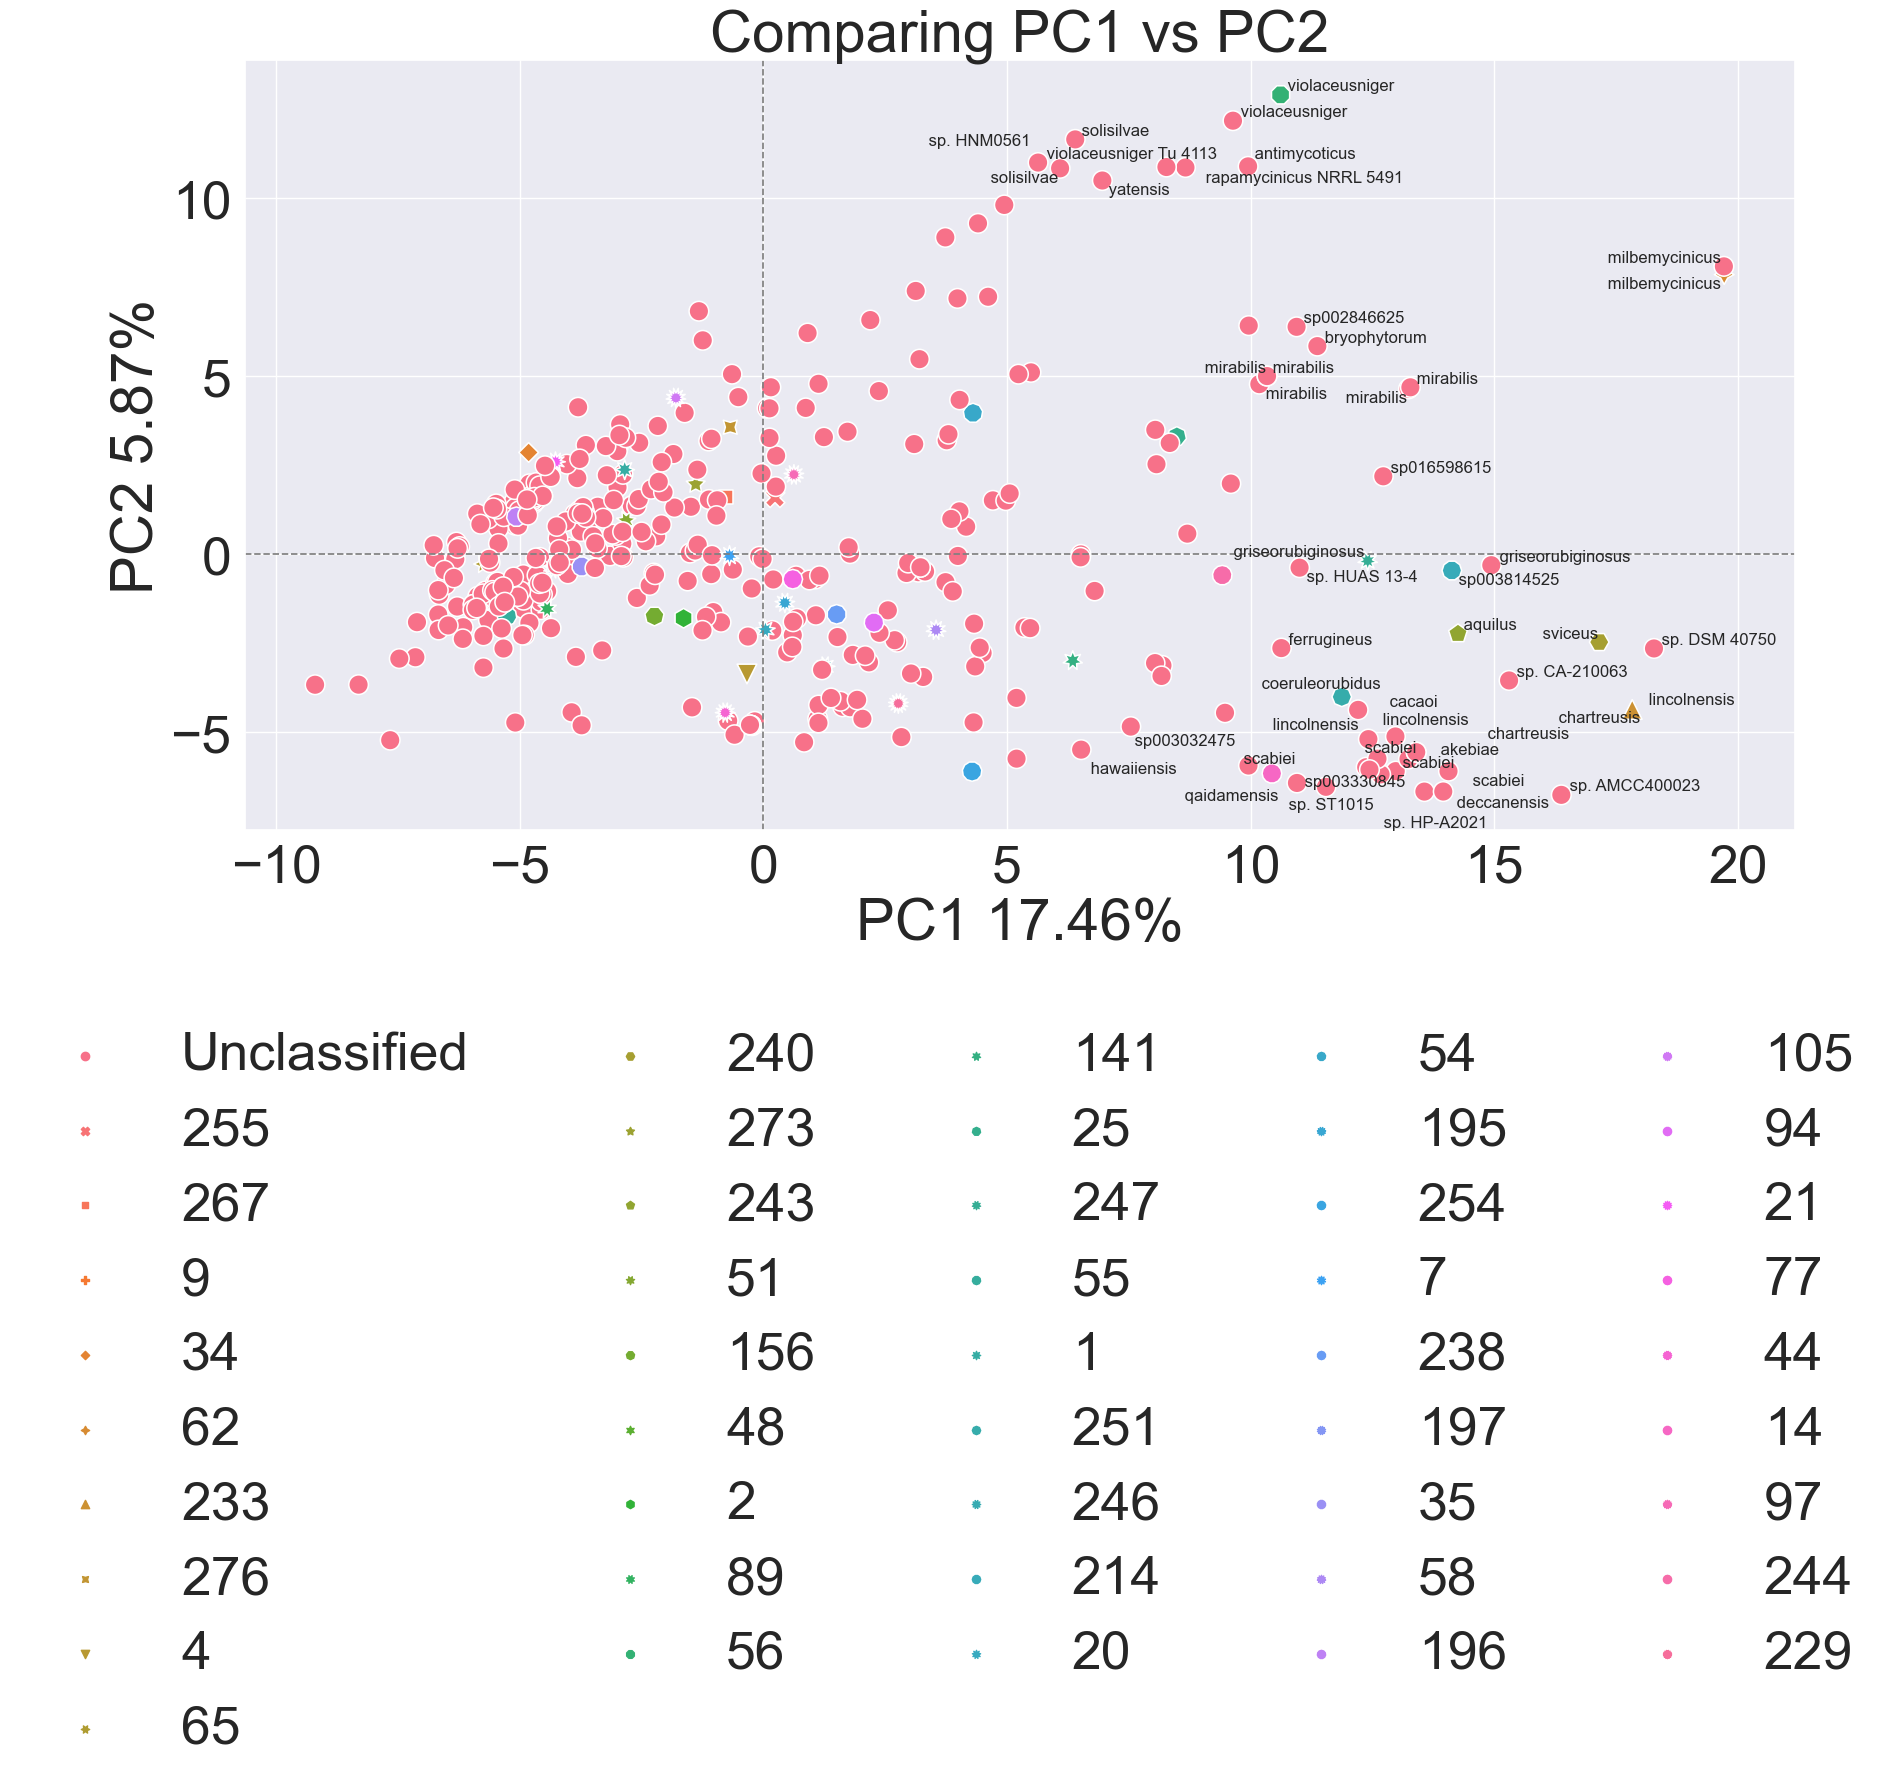

In [47]:
#3. plt pc1 vs pc2 by MLST colour
compare_pcs(0, 1,pca_df, 10, 10,"mlst", figsize=(20,10))

#Save figure
plt.savefig("../data/jupyter_results/pca_plot_PC1vsPC2_by_MLST.png",bbox_inches="tight")

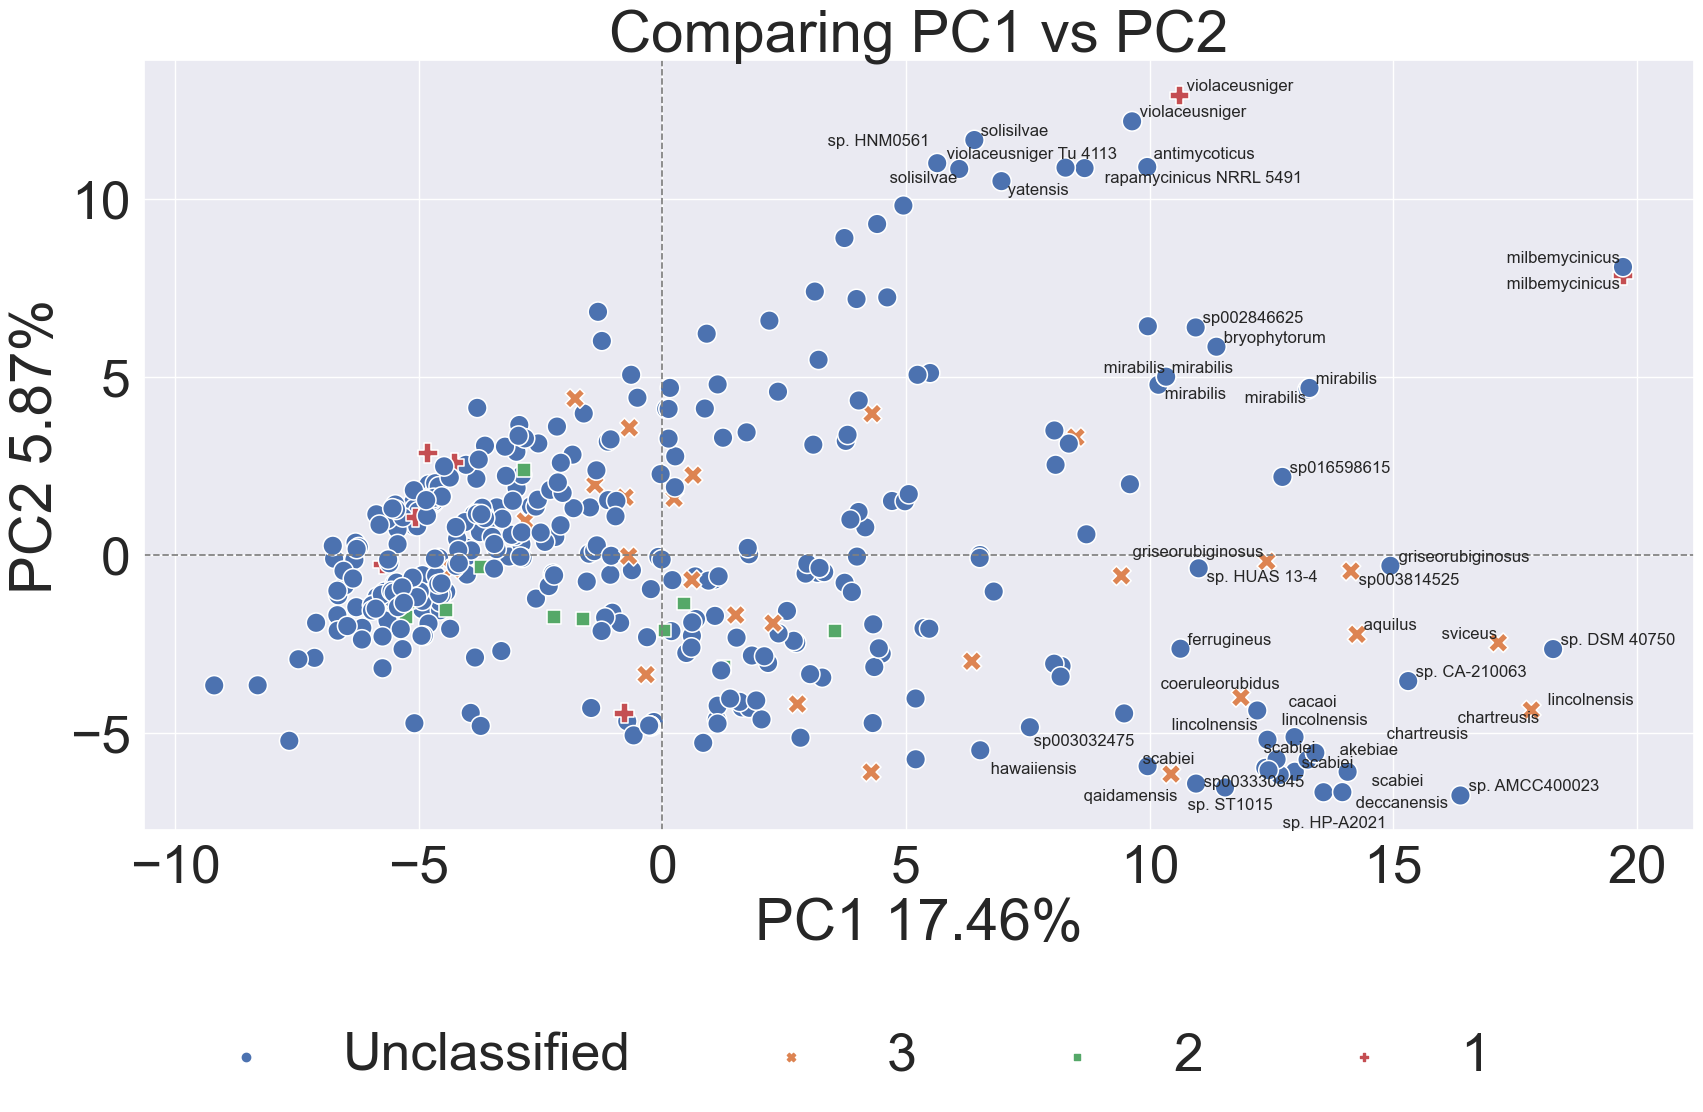

In [48]:
#4. plt pc1 vs pc2 by SCO colour
compare_pcs(0, 1,pca_df, 10, 10,"sco", figsize=(20,10))

#Save figure
plt.savefig("../data/jupyter_results/pca_plot_PC1vsPC2_by_SCO.png",bbox_inches="tight")

## 13. Loading plots and CAZy families
<a id="loading-plot"></a>
***Each line below refers to a seperate code block.***
1. Function for generating loading plot
2. Loading plot for PC1 vs PC2 



In [49]:
#1. Function for generating loading plots
def gen_loading_plot(first_pc,second_pc,df,figsize=None):

    # calculate loading = variables x loadings, returns an array
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # get the labels of our variables (i.e. CAZy family names)
    loading_labels = list(df.columns[:-3])

    loadings_x = loadings[:, first_pc] # PC1 (0)
    loadings_y = loadings[:, second_pc]  # PC2 (1)

    loadings_df = pd.DataFrame()
    loadings_df['loadings_x'] = loadings_x
    loadings_df['loadings_y'] = loadings_y

    cazy_col = []
    for lable in loading_labels:
        if lable.startswith('GH'):
             cazy_col.append('GH')
        elif lable.startswith('GT'):
             cazy_col.append('GT')
        elif lable.startswith('PL'):
             cazy_col.append('PL')
        elif lable.startswith('CE'):
             cazy_col.append('CE')
        elif lable.startswith('AA'):
             cazy_col.append('AA')
        else:
            cazy_col.append('CBM')

    loadings_df['CAZy class'] = cazy_col

    #plt.figure(figsize=(10,10))
    if figsize is not None:
        plt.figure(figsize=figsize)
        
    #Scatterplot
    g = sns.scatterplot(
        x=loadings_x,
        y=loadings_y,
        data=loadings_df,
        hue=cazy_col,
        s=50,  # size of the points on the scatter plot
    )
    g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
    g.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    
    #Axis min max
    g.set(xlim=(-1,1), ylim=(-1,1))
    
    #Axis marker size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc="upper left",fontsize=15)
    
    #Axis labels
    plt.xlabel(f"PC{first_pc + 1}",fontsize=15)
    plt.ylabel(f"PC{second_pc + 1}",fontsize=15)
    plt.title(f"Loading plot of PC{first_pc + 1 } vs PC{second_pc + 1}",fontsize=18)

    # Add on CAZy family annotations to our loadings plot 
    threshold = 0.01
    texts = [
        plt.text(
            xval,
            yval,
            lbl,
            ha='center',
            va='center',
            fontsize=14,
        ) for (xval, yval, lbl) in zip(
            loadings[:, 0], loadings[:, 1], loading_labels
        ) if abs(xval) > threshold or abs(yval) > threshold
    ]
    adjustText.adjust_text(texts, arrowsprops=dict(arrowstyle='-', color='black'));

    plt.show;

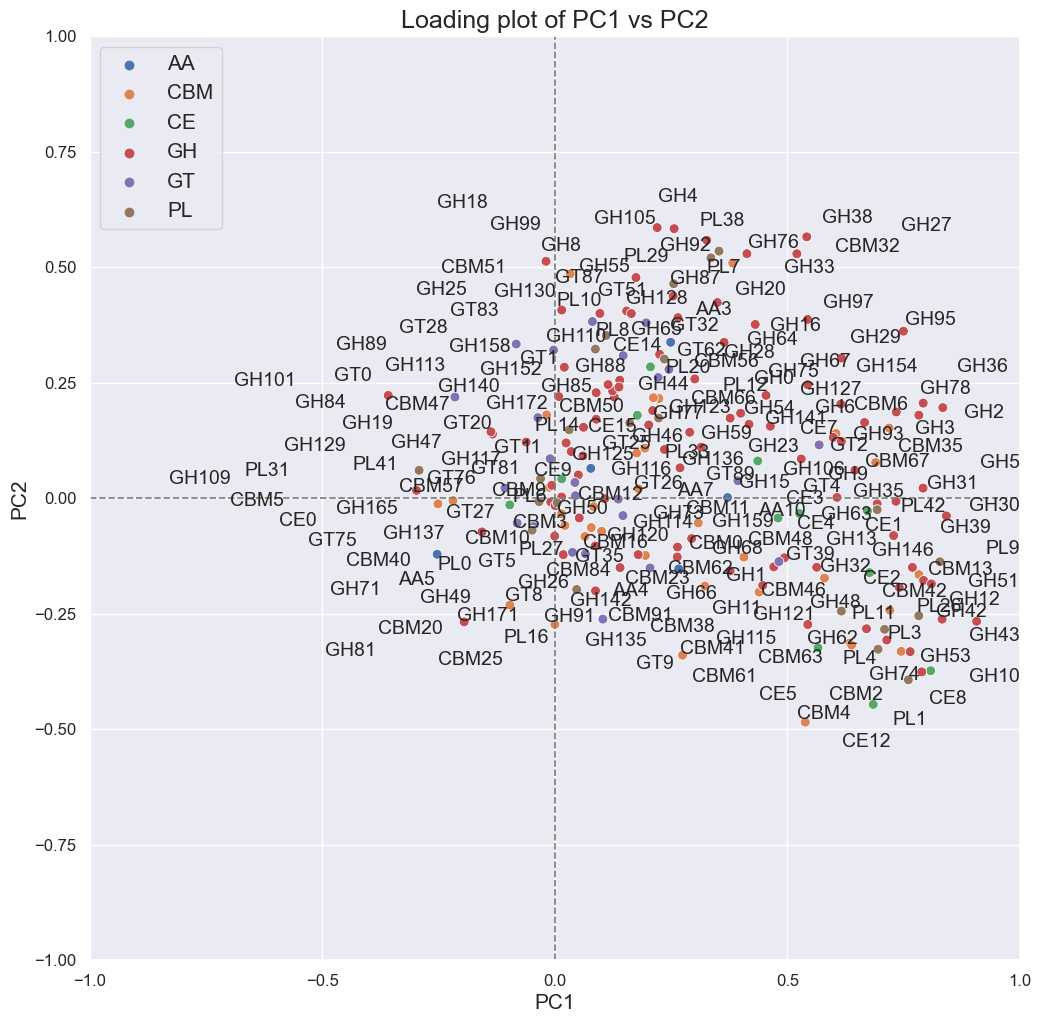

In [50]:
#2. Loading plot for PC 1 vs PC2
gen_loading_plot(0,1,pca_df,figsize=(12,12))

#Save figure
plt.savefig("../data/jupyter_results/loading_plot_PC1vsPC2.png",bbox_inches="tight")